# **MONTHLY PURCHASE PREDICTION FOR E-COMMERCE**

**Created by :**<br>
Nathania Frieska Zamris (JCDS 0106 002)<br>
Mary Amalia Wauran (JCDS 0106 006)<br>
Idam Ahmadi (JCDS 0106 007)<br>

## **Business Problem Understanding**

### Background

Kami bekerja sebagai anggota tim **data scientist** di sebuah perusahaan **Olist E-Commerce** dengan *revenue model* berupa **bagi hasil** dari penjualan *seller* di dalam platform.

**Olist E-Commerce** adalah pasar online Brazil yang menghubungkan pedagang (usaha kecil dan menengah) dengan pelanggan di seluruh Brazil. Pedagang dapat menggunakan Olist untuk menjual produk mereka secara online dan mengakses pangsa pasar yang lebih luas, layanan logistik, dan solusi pemrosesan pembayaran.

### Problem Statement

Tim kami diminta oleh tim marketing untuk **memprediksi** jumlah nilai pembelian / ***TIV (Total Item Value)*** yang akan terjadi sampai **4 bulan** kedepan (akhir tahun 2018), berdasarkan data historis perusahaan tahun 2016-2018.

### Goals

Tujuan dilakukannya prediksi tersebut agar tim marketing mendapat gambaran berapa TIV yang bisa didapatkan sampai akhir tahun dan diharapkan membantu tim marketing menentukan **budget** yang diperlukan untuk mencapai TIV tersebut.

Disini kami juga memberi beberapa rekomendasi baik dari sisi marketing maupun bukan, berdasarkan insight data yang kami temukan, diantaranya:

    1. Berapa Average Basket Size dan bagaimana kita bisa meningkatkannya?
    2. Performa kota terbaik, berapa user terakuisisi, kota mana yang mempunyai potensi growth.
    3. Kategori apa yang paling laku, potensi dan kendala apa yang mungkin dialami kategori tersebut.
    4. Berapa jumlah transaksi kita, bagaimana caranya menjaga pengelamanan berbelanja tetap baik?
    5. Adakah potensi lain yang bisa dijadikan diversifikasi produk?

**Note : Walaupun begitu analisa yang kami lakukan baru permukaan dan perlu dikaji lebih mendalam**

## **Data Understanding**

### Dataset Information

**Brazilian E-Commerce Public Dataset**
- Sumber : [kaggle.com](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_products_dataset.csv)
- Pembuat : Olist and André Sionek
- Tahun : 2018

Dataset ini adalah dataset publik dari perusahaan e-commerce Olist pada tahun 2016-2018, yang terdiri dari:
- Customer dataset
- Order items dataset
- Order payments dataset
- Orders dataset
- Products dataset
- Product category dataset

### Attribute Information

Informasi data yang digunakan :

| Nama Kolom | Tipe Data | Penjelasan |
| --- | --- | --- |
| order_id | String | Nomor unik tiap pemesanan |
| product_id | String | Nomor unik tiap produk yang ada di platform |
| purchase | Float | Harga produk/item |
| order_status | String | Status pemesanan terupdate |
| product_category_name_english | String | Kategori produk |
| customer_unique_id | String | Nomor unik tiap user (pembeli) |
| customer_city | String | Kota asal pembeli |
| customer_state | String | Negara bagian  |
| payment_type | String | Metode pembayaran yang dilakukan pembeli |
| month | Period[M] | Tahun dan bulan pemesanan |
| date | Period[D] | Tahun, bulan, dan tanggan pemesanan |

### Evaluation Metric

Evaluasi metrik yang akan digunakan adalah MAE, MAPE, MSE, dan RMSE.

- MAE (Mean Absolute Error) adalah metrik evaluasi untuk menilai kinerja model. MAE mengukur rata-rata kesalahan absolut antara nilai prediksi dan nilai sebenarnya. MAE dihitung dengan menjumlahkan kesalahan absolut untuk setiap prediksi dan kemudian membaginya dengan jumlah total prediksi.

- MAPE (Mean Absolute Percentage Error) adalah metrik evaluasi yang serupa dengan MAE, namun menggunakan persentase kesalahan absolut. MAPE mengukur rata-rata kesalahan absolut sebagai persentase dari nilai sebenarnya. MAPE berguna ketika skala data berbeda, sehingga memberikan kesalahan absolut dalam satuan yang sama tidak cukup bermakna.

- MSE (Mean Squared Error) adalah metrik evaluasi lain yang mengukur rata-rata kuadrat kesalahan antara nilai prediksi dan nilai sebenarnya. MSE dihitung dengan menjumlahkan kuadrat kesalahan untuk setiap prediksi dan kemudian membaginya dengan jumlah total prediksi.

- RMSE (Root Mean Squared Error) adalah metrik evaluasi yang serupa dengan MSE, namun mengambil akar kuadrat dari nilai MSE. RMSE memberikan ukuran kesalahan yang lebih mudah diinterpretasikan dalam satuan yang sama dengan variabel target. RMSE juga memberikan bobot yang lebih besar pada kesalahan besar, yang mungkin lebih penting dalam beberapa kasus.

Semua metrik evaluasi ini berguna untuk membandingkan performa model yang berbeda dan memilih model yang terbaik untuk kasus yang diberikan. Namun, setiap metrik evaluasi memiliki kelemahan dan kelebihan masing-masing, sehingga pilihan tergantung pada tujuan bisnis dan karakteristik data.

**MAPE**

Kami putuskan menjadikan MAPE sebagai metric penilaian karena beberapa alasan berikut:
- Grafik kita memiliki trend yang berbeda signifikan, jika menggunakan penilaian nominal error 10000 pada 2017 mungkin besar tapi di 2018 bisa jadi kecil, sedangkan dengan MAPE perbedaan persepsi seperti itu bisa dihindari
- MAPE lebih mudah dipahami oleh tim marketing

## **Data Cleaning and Preprocessing**

### Data Cleaning

#### Import Library

In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from datetime import date
from datetime import datetime
from datetime import timedelta

import sklearn.metrics as metrics

import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from prophet import Prophet

from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from PIL import Image

pd.set_option('display.max_columns', 50)

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### Load Dataset

In [65]:
customer = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
categories = pd.read_csv("product_category_name_translation.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")

#### Merge Dataset

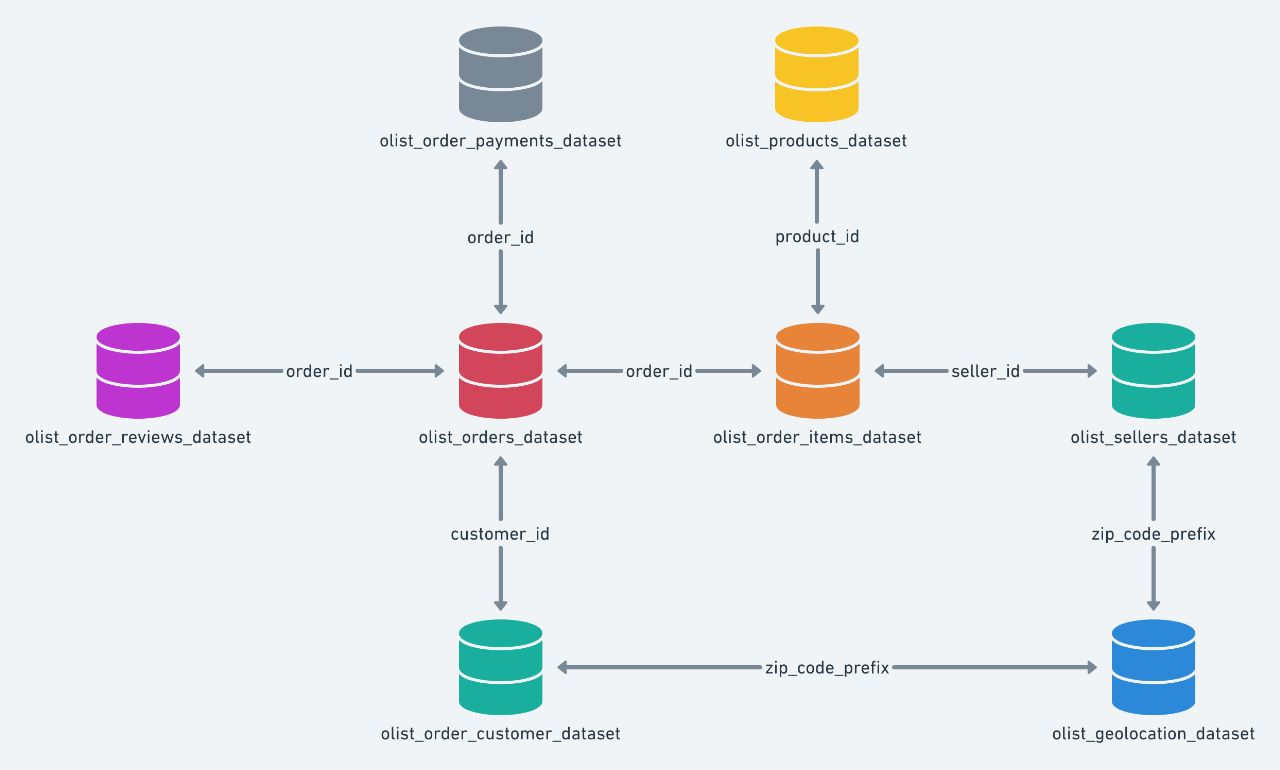

In [66]:
# Melihat kolom yang berhubungan antar dataset
from IPython.display import Image
Image('dataset.jpg')

In [67]:
# Menggabungkan data yang akan digunakan
df_orders = order_items.merge(orders, on='order_id').merge(products, on='product_id').merge(categories, on='product_category_name').merge(customer, on='customer_id').merge(order_payments, on='order_id')

# Mengubah tipe data order_purchase_timestamp menjadi tipe data datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['month'] = df_orders['order_purchase_timestamp'].dt.to_period('M')
df_orders['date'] = df_orders['order_purchase_timestamp'].dt.to_period('D')

# Mengubah nama kolom price menjadi purchase
df_orders.rename(columns={'price':'purchase'},inplace=True)

# Mengatasi jika ada data yang duplikat
if df_orders.duplicated().sum() == 0:
    print('Tidak ada data duplikat')
else:
    print(f'Berhasil {df_orders.duplicated().sum()} duplikat didrop')
    df_orders.drop_duplicates(inplace=True)

Tidak ada data duplikat


### Exploratory Data Analysis and Preprocessing

In [68]:
# Mengetahui informasi data df_orders
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   order_item_id                  115878 non-null  int64         
 2   product_id                     115878 non-null  object        
 3   seller_id                      115878 non-null  object        
 4   shipping_limit_date            115878 non-null  object        
 5   purchase                       115878 non-null  float64       
 6   freight_value                  115878 non-null  float64       
 7   customer_id                    115878 non-null  object        
 8   order_status                   115878 non-null  object        
 9   order_purchase_timestamp       115878 non-null  datetime64[ns]
 10  order_approved_at              115864 non-null  object        
 11  

In [69]:
# Pemilihan dan deskripsi singkat fitur yang dipilih
df_orders = df_orders[[
    'order_id',                       # nomor unik tiap pemesanan
    'product_id',                     # nomor unik tiap produk yang ada di platform
    'purchase',                       # harga produk
    'order_status',                   # status pemesanan terupdate    
    'product_category_name_english',  # kategori product
    'customer_unique_id',             # nomor unik tiap user (pembeli)
    'customer_city',                  # kota auser
    'customer_state',                 # state (provinsi) user
    'payment_type',                   # metode pembayaran   
    'order_purchase_timestamp',       # waktu pemesanan             
    'month',                          # tahun dan bulan pemesanan
    'date',                           # tahun, bulan dan tanggal pemesanan                                      
]]
df_orders.head(1)

,order_id,product_id,purchase,order_status,product_category_name_english,customer_unique_id,customer_city,customer_state,payment_type,order_purchase_timestamp,month,date
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,delivered,cool_stuff,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,credit_card,2017-09-13 08:59:02,2017-09,2017-09-13


In [70]:
# Informasi data df_orders yang akan digunakan dalam analisis dan modeling
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   product_id                     115878 non-null  object        
 2   purchase                       115878 non-null  float64       
 3   order_status                   115878 non-null  object        
 4   product_category_name_english  115878 non-null  object        
 5   customer_unique_id             115878 non-null  object        
 6   customer_city                  115878 non-null  object        
 7   customer_state                 115878 non-null  object        
 8   payment_type                   115878 non-null  object        
 9   order_purchase_timestamp       115878 non-null  datetime64[ns]
 10  month                          115878 non-null  period[M]     
 11  

In [71]:
# Memastikan apakah terdapat missing value pada data
df_orders.isna().sum()

# Data lengkap, tidak ada missing value

order_id                         0
product_id                       0
purchase                         0
order_status                     0
product_category_name_english    0
customer_unique_id               0
customer_city                    0
customer_state                   0
payment_type                     0
order_purchase_timestamp         0
month                            0
date                             0
dtype: int64

In [72]:
# Melihat jenis-jenis status pemesanan:
df_orders['order_status'].unique()

array(['delivered', 'shipped', 'invoiced', 'canceled', 'processing',
       'unavailable', 'approved'], dtype=object)

In [73]:
# Tidak menggunakan data dengan status pemesanan 'canceled'
# Karna order status canceled dapat diartikan transaksi tidak berhasil
df_orders = df_orders[~(df_orders['order_status']=='canceled')]

print('Sudah tidak ada pemesanan status canceled')
df_orders['order_status'].unique()

Sudah tidak ada pemesanan status canceled


array(['delivered', 'shipped', 'invoiced', 'processing', 'unavailable',
       'approved'], dtype=object)

In [74]:
# Membuat dataframe purchase yang berhubungan dengan tanggal 
# Data purchase yang dikelompokkan berdasarkan bulan
df_ym = df_orders[['month','purchase']].groupby(by='month').sum()[['purchase']].reset_index()
df_ym.rename(columns={'month':'date'},inplace=True)

# Data purchase yang dikelompokkan berdasarkan tanggal
df_ymd = df_orders[['date','purchase']].groupby(by='date').sum()[['purchase']].reset_index()
df_ymd.rename(columns={'month':'date'},inplace=True)
df_ymd['year'] = df_ymd['date'].dt.year
df_ymd['month'] = df_ymd['date'].dt.month
df_ymd['day'] = df_ymd['date'].dt.day
df_ymd['weekday'] = df_ymd['date'].dt.weekday

# Data prophet
df_prophet = df_orders[['order_purchase_timestamp','purchase','date']]
df_prophet.columns = ['ds','y','date']

# Menampilkan ketiga data diatas 
display(
    df_ym.head(),
    df_ymd.head(),
    df_prophet.head()
)


,date,purchase
0,2016-09,72.89
1,2016-10,47883.67
2,2016-12,10.90
3,2017-01,126720.75
4,2017-02,249329.29


,date,purchase,year,month,day,weekday
0,2016-09-04,72.89,2016,9,4,6
1,2016-10-03,441.98,2016,10,3,0
2,2016-10-04,10068.47,2016,10,4,1
3,2016-10-05,8474.15,2016,10,5,2
4,2016-10-06,6660.52,2016,10,6,3


,ds,y,date
0,2017-09-13 08:59:02,58.9,2017-09-13
1,2017-06-28 11:52:20,55.9,2017-06-28
2,2018-05-18 10:25:53,64.9,2018-05-18
3,2017-08-01 18:38:42,58.9,2017-08-01
4,2017-08-10 21:48:40,58.9,2017-08-10


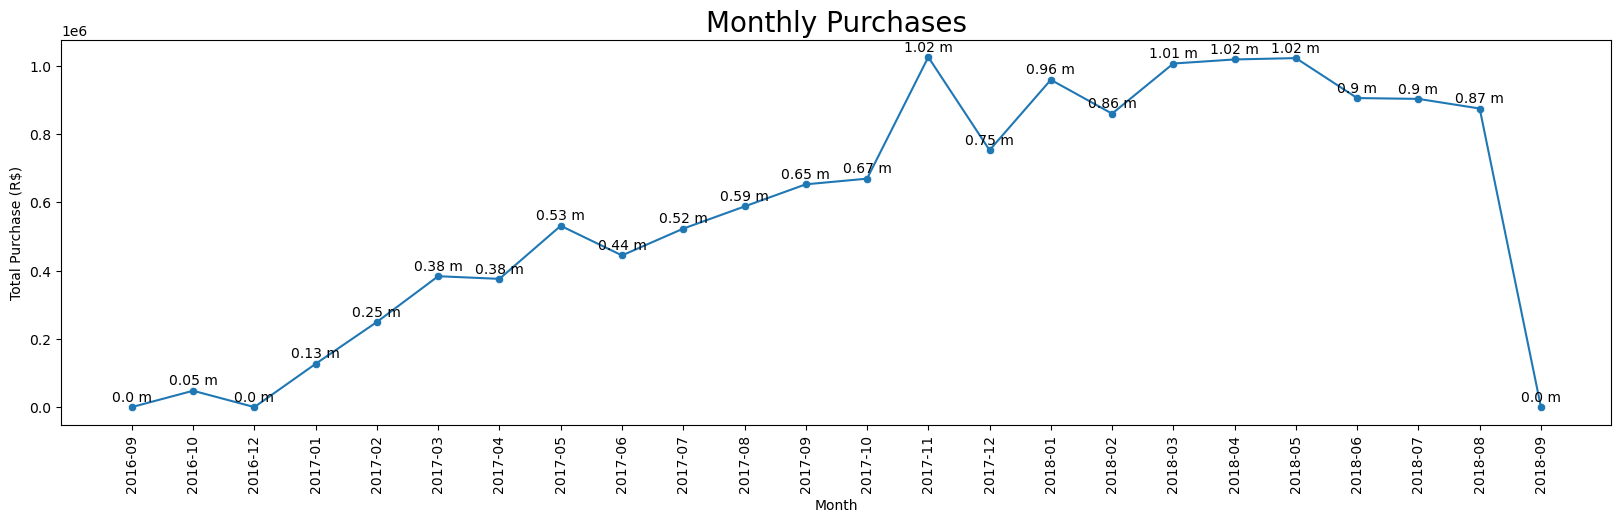

In [75]:
# Menampilkan grafik jumlah pembelian selama 2 tahun (September 2016-September 2018)
# Mengubah tipe data date menjadi string untuk membuat lineplot
df_monthly = df_ym.copy()
df_monthly['date'] = df_monthly['date'].astype(str)

# Membuat lineplot dan scatterplot
plt.figure(figsize = (20,5))
ax = sns.lineplot(data = df_monthly, x='date', y='purchase')
sns.scatterplot(data = df_monthly, x='date', y='purchase')

# Memberikan annotate pada grafik
for i, value in enumerate(df_monthly['purchase']):
    text = f'{round(value/1e6, 2)} m'
    ax.annotate(text, xy=(df_monthly['date'][i], value),
                xytext=(df_monthly['date'][i], value+50000),
                ha='center', va='top')

plt.xticks(rotation = 90)
plt.xticks(range(len(df_monthly)))
plt.title('Monthly Purchases', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')

plt.show()

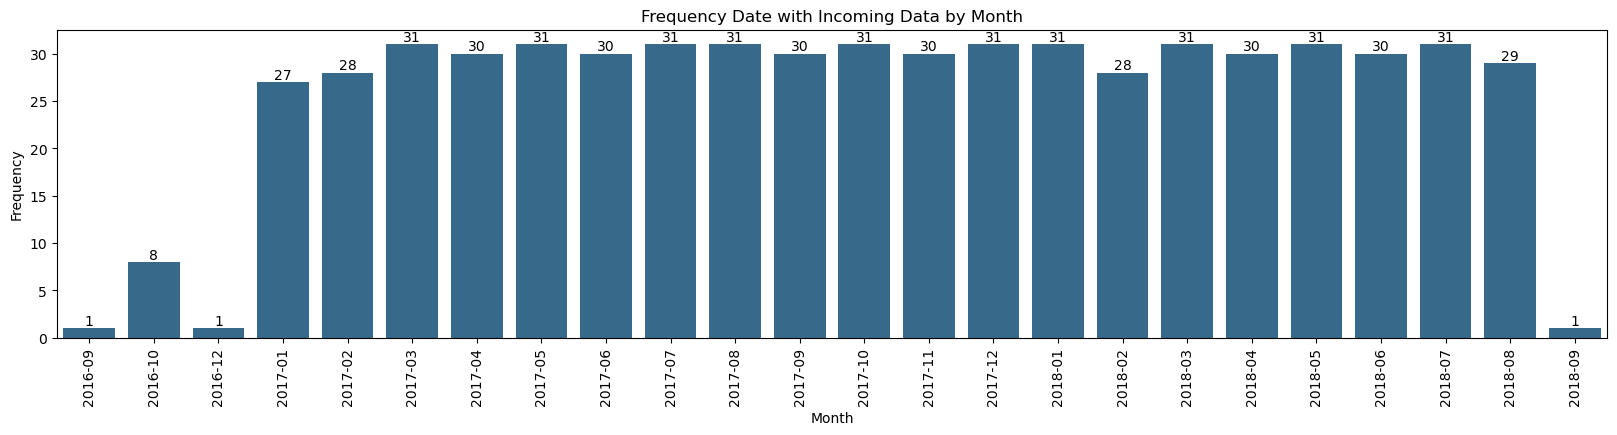

In [76]:
# Mengetahui kelengkapan data dari setiap bulan
df_support = df_ym.copy()
df_support2 = df_ymd.groupby(by=['year','month']).count().reset_index()
df_support.insert(len(df_support.columns),'n_day',df_support2['date'])
df_support['date'] = df_support['date'].astype(str)

plt.figure(figsize = (20,4))
barplot = sns.barplot(data=df_support,x='date',y='n_day',color='#296d98')
plt.xticks(rotation = 90)
plt.xticks(range(len(df_support)))

for bar in barplot.containers:
    barplot.bar_label(bar, label_type='edge', labels=[ int(h) for h in bar.datavalues])

barplot.set(xlabel='Month', ylabel='Frequency',
       title='Frequency Date with Incoming Data by Month')
plt.show()

Grafik diatas menunjukan jumlah pembelian selama 2 tahun **(September 2016 - September 2018)**
- Bulan November 2016 tidak ada data-nya sama sekali
- Bulan September, Oktober, Desember 2016 banyak data harian yang tidak ada
- Bulan September 2018 data yang masuk baru 1 hari
- Bulan-bulan diatas tidak akan digunakan untuk analisa maupun modeling

In [77]:
# Membersihkan dari data yang tidak dipakai 
# Membuang data yang tidak lengkap
df_orders = df_orders[(df_orders['month']>='2017-01')&(df_orders['month']<'2018-09')]


#### Monthly Purchases

In [78]:
# Membuat df baru dengan melakukan agregat data berdasarkan bulan
df_ym = df_orders[['month','purchase']].groupby(by='month').sum()[['purchase']].reset_index()
df_ym.rename(columns={'month':'date'},inplace=True)

# Membuat df baru dengan melakukan agregat data berdasarkan tanggal
df_ymd = df_orders[['date','purchase']].groupby(by='date').sum()[['purchase']].reset_index()
df_ymd.rename(columns={'month':'date'},inplace=True)
df_ymd['year'] = df_ymd['date'].dt.year
df_ymd['month'] = df_ymd['date'].dt.month
df_ymd['day'] = df_ymd['date'].dt.day
df_ymd['weekday'] = df_ymd['date'].dt.weekday

# Membuat df untuk modeling menggunakan fbprophet
df_prophet = df_orders[['order_purchase_timestamp','purchase','date']]
df_prophet.columns = ['ds','y','date']

# Menampilkan ketiga dataframe di atas
display(
    df_ym.head(),
    df_ymd.head(),
    df_prophet.head()
)

,date,purchase
0,2017-01,126720.75
1,2017-02,249329.29
2,2017-03,383283.91
3,2017-04,375531.37
4,2017-05,530888.38


,date,purchase,year,month,day,weekday
0,2017-01-05,396.90,2017,1,5,3
1,2017-01-06,3460.38,2017,1,6,4
2,2017-01-07,1351.90,2017,1,7,5
3,2017-01-08,709.58,2017,1,8,6
4,2017-01-09,673.79,2017,1,9,0


,ds,y,date
0,2017-09-13 08:59:02,58.9,2017-09-13
1,2017-06-28 11:52:20,55.9,2017-06-28
2,2018-05-18 10:25:53,64.9,2018-05-18
3,2017-08-01 18:38:42,58.9,2017-08-01
4,2017-08-10 21:48:40,58.9,2017-08-10


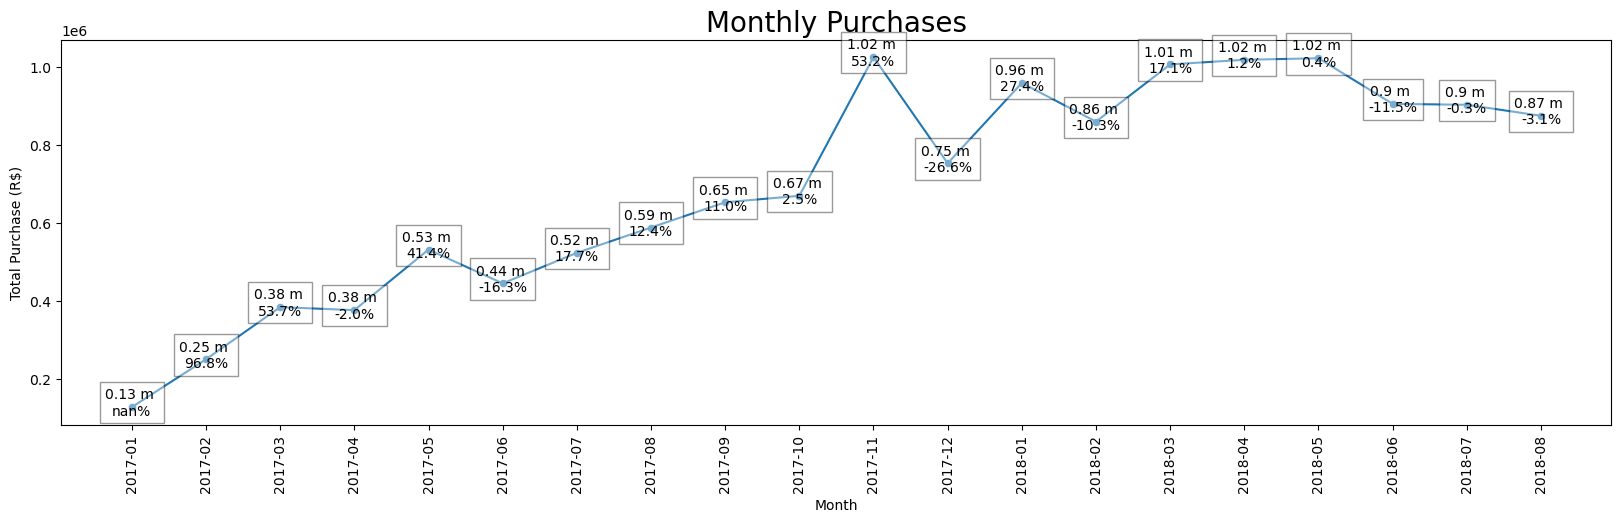

In [79]:
# Membuat grafik monthly purchases
df_monthly = df_ym.copy()
df_monthly['date'] = df_monthly['date'].astype(str)

# Menambahkan kolom baru ke data frame
df_monthly['pct_change'] = df_monthly['purchase'].pct_change() * 100

plt.figure(figsize = (20,5))
ax = sns.lineplot(data = df_monthly, x='date', y='purchase')
sns.scatterplot(data = df_monthly, x='date', y='purchase')

# Memberikan annotate pada grafik
for i, value in enumerate(df_monthly['purchase']):
    text = f'''{round(value/1e6, 2)} m 
{round(df_monthly["pct_change"][i], 1)}%'''
    ax.annotate(text, xy=(df_monthly['date'][i], value),
                xytext=(df_monthly['date'][i], value+50000),
                ha='center', va='top', bbox=dict(facecolor='white', alpha=0.4))

plt.xticks(rotation = 90)
plt.xticks(range(len(df_monthly)))
plt.title('Monthly Purchases', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')

plt.show()

In [80]:
# Jumlah pembelian setiap bulan 
df_monthly

,date,purchase,pct_change
0,2017-01,126720.75,NaN
1,2017-02,249329.29,96.754904
2,2017-03,383283.91,53.725986
3,2017-04,375531.37,-2.022663
4,2017-05,530888.38,41.369915
5,2017-06,444194.14,-16.330032
6,2017-07,522608.10,17.653083
7,2017-08,587550.63,12.426621
8,2017-09,652353.58,11.029339
9,2017-10,668953.61,2.544637


Berdasarkan dari Grafik di atas, dapat diketahui bahwa:
- Jumlah pembelian setiap bulannya cenderung meningkat
- Jumlah pembelian paling banyak pada bulan November 2017 yaitu sebesar 1.024.942 R$
- Jumlah pembelian paling sedikit pada bulan Januari 2017 yaitu sebanyak 126.720 R$
- Jumlah pembelian mengalami peningkatan secara signifikan sebesar 53,2% yaitu pada bulan November 2017
- Jumlah pembelian mengalami penurunan secara signifikan sebesar 26,6% yaitu pada bulan Desember 2017

Ternyata ada anomali terjadi, setelah ditelusuri ternyata di tanggal 24-25 November terjadi event black friday. Setelah melihat grafik kami putuskan membuat tanggal 23 - 28 November memiliki feature black friday

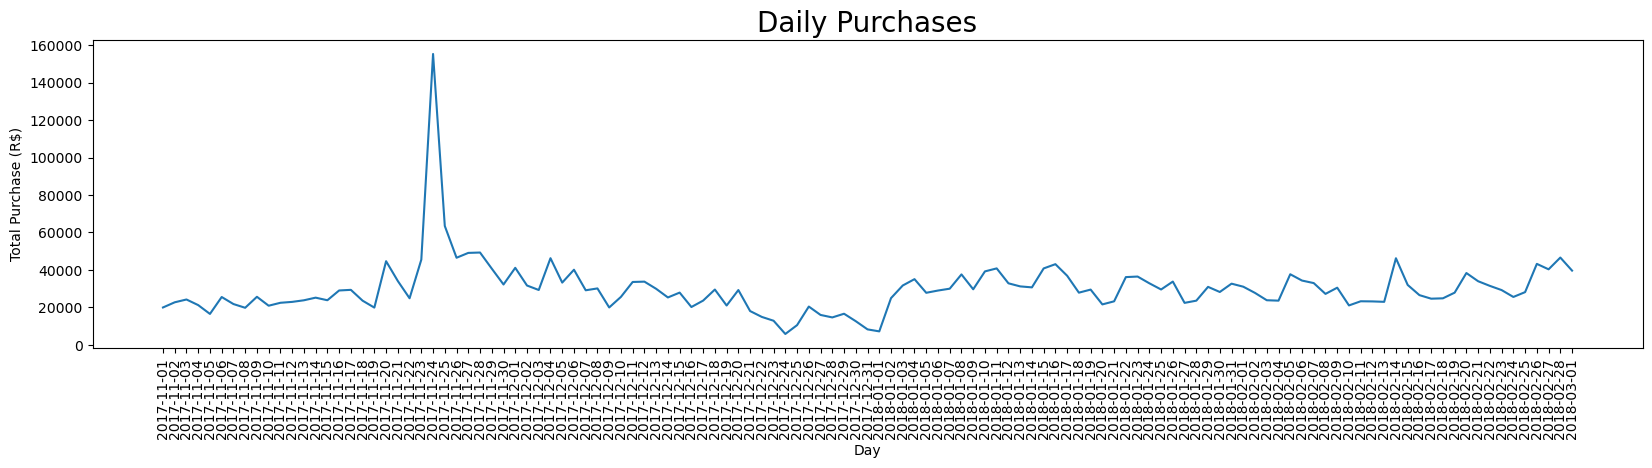

In [81]:
# Membuat grafik daily purchases untuk melihat peningkatan pembelian yang signifikan akibat event black friday 
df_support = df_ymd.copy()
df_support = df_support[(df_support['date']>='2017-11') & (df_support['date']<='2018-03')]
df_support['date'] = df_support['date'].astype(str)

plt.figure(figsize = (20,4))
sns.lineplot(data = df_support, x='date', y='purchase')
plt.xticks(rotation = 90)
plt.xticks(range(len(df_support)))

plt.title('Daily Purchases', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Day')
plt.show()

In [82]:
# Menambahkan feature black friday
df_ymd['black_friday'] = (df_ymd['month']==11) & (df_ymd['day'].between(23,28))
df_ymd['black_friday'] = np.where(df_ymd['black_friday'] == True, 1, 0)
df_ymd

,date,purchase,year,month,day,weekday,black_friday
0,2017-01-05,396.90,2017,1,5,3,0
1,2017-01-06,3460.38,2017,1,6,4,0
2,2017-01-07,1351.90,2017,1,7,5,0
3,2017-01-08,709.58,2017,1,8,6,0
4,2017-01-09,673.79,2017,1,9,0,0
...,...,...,...,...,...,...,...
597,2018-08-25,10711.93,2018,8,25,5,0
598,2018-08-26,8235.71,2018,8,26,6,0
599,2018-08-27,4870.87,2018,8,27,0,0
600,2018-08-28,3757.51,2018,8,28,1,0


#### Quarterly Purchases

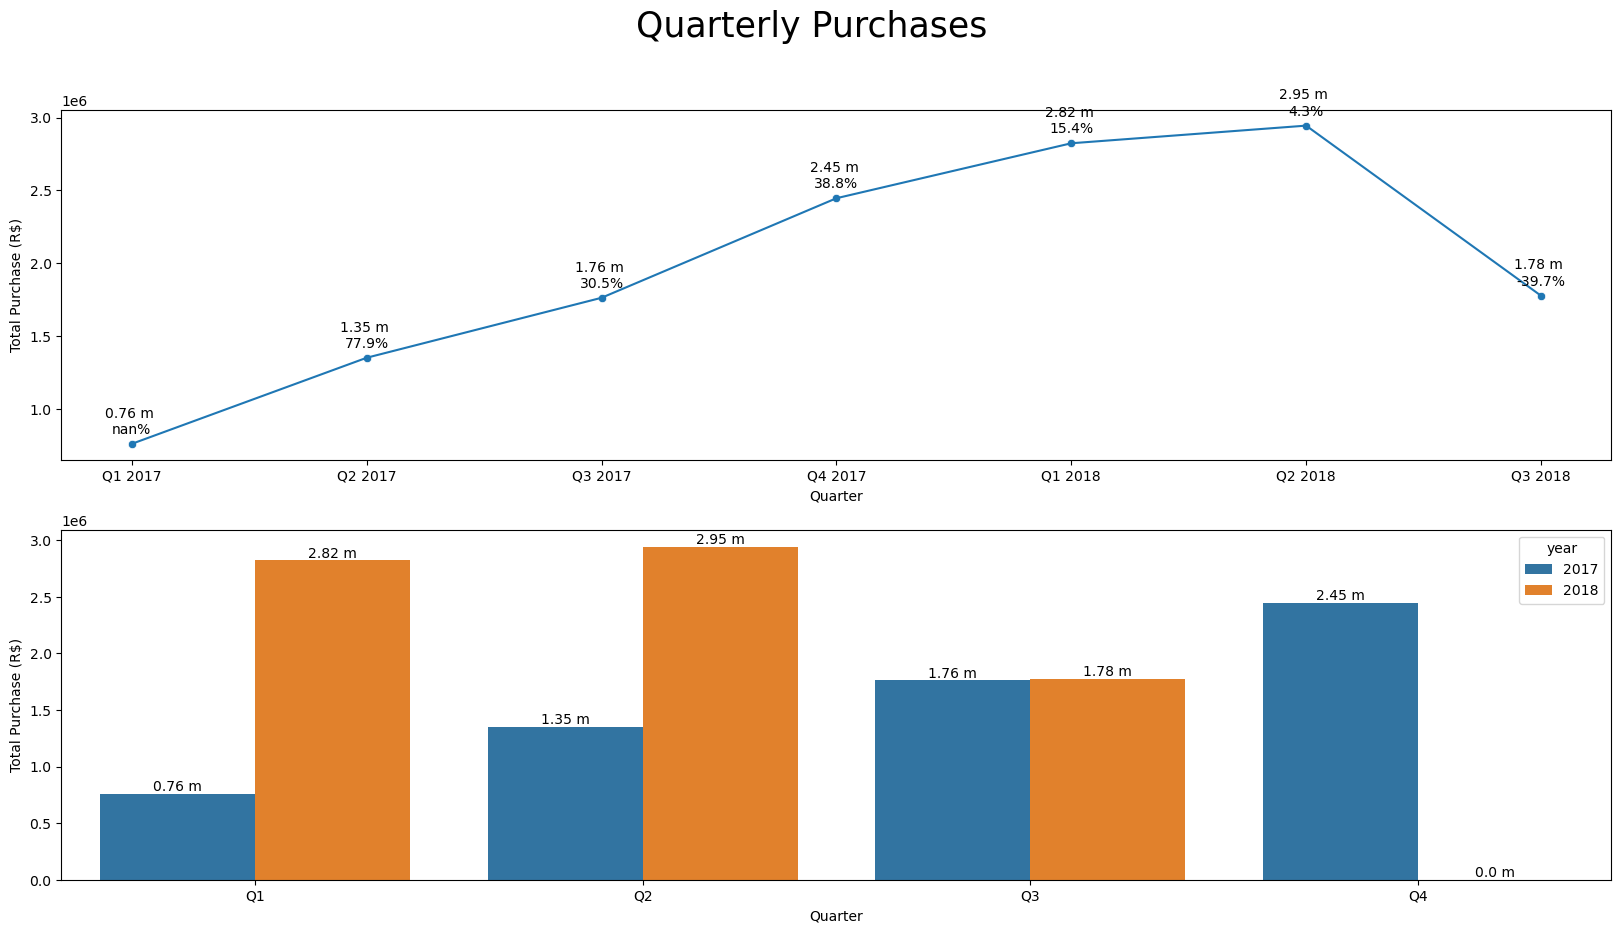

In [83]:
# Membuat kolom quarter dengan membagi data berdasarkan kuarter
df_ymd['quarter'] = (df_ymd['month'] - 1) // 3 + 1

# Membuat kolom year_quarter dengan menggabungkan kolom tahun dan kolom quarter
df_ymd['year_quarter'] = df_ymd['year'].astype(str) + '-Q' + df_ymd['quarter'].astype(str)

# Melakukan agregat data berdasarkan year_kuarter dengan menjumlahkan purchase
df_quarter = df_ymd.groupby('year_quarter')['purchase'].sum().reset_index()

# Menambahkan kolom baru ke data frame
df_quarter['pct_change'] = df_quarter['purchase'].pct_change() * 100

# Membuat grafik lineplot dan barplot
plt.figure(figsize=(20, 10))

## LINEPLOT
plt.subplot(2,1,1)
lineplot = sns.lineplot(data=df_quarter, x='year_quarter', y='purchase')
sns.scatterplot(data=df_quarter, x='year_quarter', y='purchase')
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Quarter')
labels = ['Q{} {}'.format(q, y) for y in range(df_ymd['year'].min(), df_ymd['year'].max() + 1) for q in range(1, 5)]
lineplot.set_xticklabels(labels=labels)

## Menambahkan annotate pada lineplot
for i, value in enumerate(df_quarter['purchase']):
    text = f'''{round(value/1e6, 2)} m 
{round(df_quarter["pct_change"][i], 1)}%'''
    lineplot.annotate(text, xy=(df_quarter['year_quarter'][i], value), 
                      xytext=(df_quarter['year_quarter'][i], value+50000),
                      ha='center', va='bottom')

## BARPLOT 
plt.subplot(2,1,2)
barplot = sns.barplot(data=df_ymd, x='quarter', y='purchase', hue='year', estimator=np.sum, errorbar=('ci',0))
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Quarter')
barplot.set_xticklabels(labels=['Q1', 'Q2', 'Q3', 'Q4'])

## Menambahkan annotate pada barplot
for bar in barplot.containers:
    barplot.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in bar.datavalues])


plt.suptitle('Quarterly Purchases', size=25)
plt.show()

In [84]:
# Jumlah pembelian setiap triwulan
df_quarter

,year_quarter,purchase,pct_change
0,2017-Q1,759333.95,NaN
1,2017-Q2,1350613.89,77.868234
2,2017-Q3,1762512.31,30.497126
3,2017-Q4,2446292.51,38.795769
4,2018-Q1,2823884.35,15.435269
5,2018-Q2,2945032.57,4.290127
6,2018-Q3,1776893.22,-39.664735


Note: Pada Q3 tahun 2018 data belum lengkap, karena tidak data bulan September, sehingga terlihat pada quarter tersebut mengalami penurunan

Berdasarkan dari Grafik di atas, dapat diketahui bahwa:
- Jumlah pembelian setiap quarter (triwulan) meningkat
- Jumlah pembelian paling banyak pada Q2 2018 yaitu sebesar 2.945.032 R$
- Jumlah pembelian paling sedikit pada Q1 2017 yaitu sebanyak 759.333 R$
- Jumlah pembelian mengalami peningkatan secara signifikan sebesar 77,9% yaitu pada Q2 2017
- Jumlah pembelian mengalami penurunan secara signifikan sebesar 4,3% yaitu pada Q2 2018

## **Analytic Approach**

Kami akan membangun suatu model yang akan membantu perusahaan untuk dapat menyediakan 'tool' prediksi pembelian yang mana akan berguna untuk menentukan budget marketing. Forecasting untuk 4 bulan ke depan dilakukan dengan mencoba modeling menggunakan Fbprophet, ARIMA dan ElasticNet. Metric yang digunakan adalah MAPE dan perbandingan grafik antar modelnya sebagai penilaian.

## **Modeling**

Membuat *metric* penilaian untuk *regression model* yang akan kami buat

In [85]:
# Regression metrics
def regression_results(y_true, y_pred):

    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mean_absolute_percentage_error=metrics.mean_absolute_percentage_error(y_true, y_pred)  
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('MAE: ', round(mean_absolute_error,4))
    print('MAPE: ', round(mean_absolute_percentage_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

    sns.scatterplot(y_pred,y_true-y_pred)

Split train dan test data dengan ratio 80:20 atau 16:4 bulan 

In [86]:
# Melakukan splitting data menjadi data train dan data test

# Acuan untuk splitting data yaitu pada bulan Mei 2018
date_split = '2018-05'

# Data train: data sebelum bulan Mei 2018
# Sebanyak 481 data atau sebesar 79.9%
data_train = df_ymd[~(df_ymd['date']>=date_split)]
X_train = df_ymd[~(df_ymd['date']>=date_split)][['year','month','day','weekday']]
y_train = df_ymd[~(df_ymd['date']>=date_split)]['purchase']

# Data test: data bulan Mei 2018 dan setelahnya
# Sebanyak 121 data atau sebesar 20.1%
data_test = df_ymd[(df_ymd['date']>=date_split)]
X_test = df_ymd[(df_ymd['date']>=date_split)][['year','month','day','weekday']]
y_test = df_ymd[(df_ymd['date']>=date_split)]['purchase']

# Menampilkan hasil splitting data
display(
    X_train,
    y_train,
    X_test,
    y_test
)

,year,month,day,weekday
0,2017,1,5,3
1,2017,1,6,4
2,2017,1,7,5
3,2017,1,8,6
4,2017,1,9,0
...,...,...,...,...
476,2018,4,26,3
477,2018,4,27,4
478,2018,4,28,5
479,2018,4,29,6


0        396.90
1       3460.38
2       1351.90
3        709.58
4        673.79
         ...   
476    33308.94
477    41010.46
478    23570.74
479    20072.60
480    36181.80
Name: purchase, Length: 481, dtype: float64

,year,month,day,weekday
481,2018,5,1,1
482,2018,5,2,2
483,2018,5,3,3
484,2018,5,4,4
485,2018,5,5,5
...,...,...,...,...
597,2018,8,25,5
598,2018,8,26,6
599,2018,8,27,0
600,2018,8,28,1


481    34289.19
482    41057.03
483    42749.04
484    40265.53
485    28354.83
         ...   
597    10711.93
598     8235.71
599     4870.87
600     3757.51
601     1546.04
Name: purchase, Length: 121, dtype: float64

### Prophet (fbprophet) Time-Series Model

FBProphet adalah sebuah library open source yang dikembangkan oleh Facebook untuk memprediksi data time series. FBProphet menggunakan model additive regression yang menggabungkan beberapa komponen utama dari sebuah time series, yaitu trend, musiman, dan efek liburan.

In [87]:
# Mempersiapkan data untuk train dan test menggunakan library FBProphet untuk memprediksi data time series.
# Melakukan filtering pada dataframe df_prophet untuk memilih data antara Januari 2017-31 Agustus 2018
df_prophet = df_prophet[(df_prophet['date']>='2017-01') & (df_prophet['date']<'2018-09')]

# Membuat data train untuk modeling prophet
X_train_prophet = df_prophet[~(df_prophet['ds']>=date_split)][['ds','y']]
X_train_prophet['ds'] = X_train_prophet['ds'].dt.date
X_train_prophet = X_train_prophet.groupby(by='ds').sum().reset_index()

# Membuat data test untuk modeling prophet
X_test_prophet = df_prophet[(df_prophet['ds']>=date_split)][['ds','y']]
X_test_prophet['ds'] = X_test_prophet['ds'].dt.date
X_test_prophet = X_test_prophet.groupby(by='ds').sum().reset_index()

In [88]:
# Proses penggunaan library FBProphet untuk memprediksi data time series
prophet = Prophet()
prophet.fit(X_train_prophet)

df_support = prophet.predict(X_test_prophet)
yhat_pred = df_support['yhat']

data_test = df_ymd[(df_ymd['date']>=date_split)]

data_test.insert(len(data_test.columns),column='pred',value=yhat_pred.values)
df_support = data_test.groupby(by='month').sum()['pred'].reset_index()

data_pred = df_ym[(df_ym['date']>=date_split) & (df_ym['date']<'2018-09')].copy()
data_pred['pred'] = list(df_support['pred'])

# Menghitung metrik evaluasi performa model
prophet_metrics = regression_results(data_pred['purchase'], data_pred['pred'])
prophet_metrics

17:18:14 - cmdstanpy - INFO - Chain [1] start processing
17:18:14 - cmdstanpy - INFO - Chain [1] done processing


MAE:  226795.1573
MAPE:  0.2508
MSE:  58933131843.1957
RMSE:  242761.4711


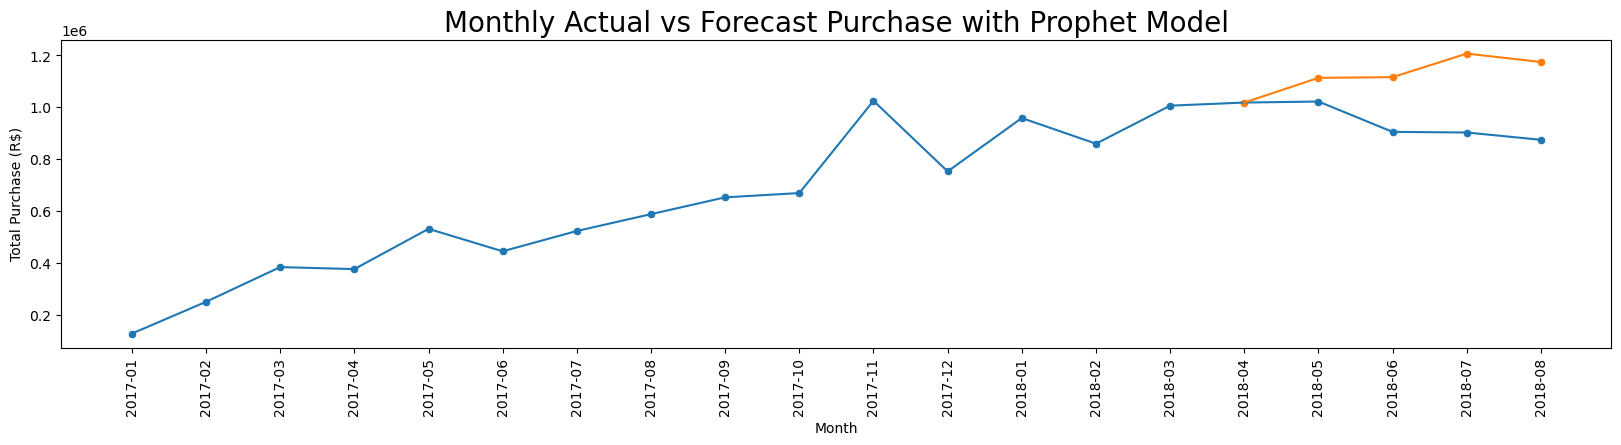

In [89]:
# Membuat grafik untuk melihat perbandingan data aktual dan data prediksi 
plt.figure(figsize = (20,4))

# Purchase Aktual
df_support = df_ym.copy()
df_support['date'] = df_support['date'].astype(str)
sns.lineplot(data = df_support, x='date', y='purchase')
sns.scatterplot(data = df_support, x='date', y='purchase')

# Purchase Prediksi
df_support2 = df_ym[df_ym['date']==min(data_pred['date']) - 1].copy()
df_support2.rename(columns={'purchase':'pred'},inplace=True)
df_support2 = pd.concat([df_support2,data_pred[['date','pred']]])
df_support2['date'] = df_support2['date'].astype(str)
sns.lineplot(data = df_support2, x='date', y='pred')
sns.scatterplot(data = df_support2, x='date', y='pred')

plt.xticks(rotation = 90)
plt.xticks(range(len(df_support)))
plt.title('Monthly Actual vs Forecast Purchase with Prophet Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

### ARIMA Model

ARIMA (Autoregressive Integrated Moving Average) adalah metode statistik yang digunakan untuk menganalisis dan memprediksi data time series. ARIMA memiliki tiga komponen utama yaitu Autoregression (AR), Integration (I), dan Moving Average (MA).

- **Autoregression (AR)** adalah konsep di mana nilai-nilai masa lalu dari suatu time series digunakan untuk memprediksi nilai masa depan. Autoregressive dapat didefinisikan sebagai persamaan yang menghubungkan nilai time series saat ini dengan nilai sebelumnya.

- **Integration (I)** adalah konsep di mana pengurangan nilai time series dilakukan untuk membuat data time series menjadi stasioner. Data stasioner adalah data yang memiliki rata-rata dan variansi yang konstan dari waktu ke waktu. Pengurangan ini dilakukan dengan mengurangi nilai time series pada waktu sebelumnya dari nilai time series pada waktu saat ini.

- **Moving Average (MA)** adalah konsep di mana pergerakan rata-rata dari data time series digunakan untuk memprediksi nilai masa depan. Konsep ini melibatkan penggunaan nilai rata-rata dari sejumlah titik sebelumnya untuk memprediksi nilai berikutnya.

ARIMA bekerja dengan cara menggabungkan ketiga komponen tersebut menjadi satu model. Langkah pertama adalah mengidentifikasi komponen-komponen tersebut dalam data time series yang akan diprediksi. Kemudian, model ARIMA dibangun dengan menentukan jumlah autoregressive terms (p), jumlah integrated terms (d), dan jumlah moving average terms (q) yang sesuai dengan data time series. Setelah model dibangun, langkah selanjutnya adalah melakukan estimasi parameter dan validasi model.

Estimasi parameter dilakukan dengan mencari nilai-nilai parameter yang terbaik untuk model yang dibangun. Validasi model dilakukan dengan membandingkan hasil prediksi model dengan data yang sebenarnya. Jika hasil prediksi model cukup akurat, maka model dapat digunakan untuk memprediksi nilai masa depan dari data time series.

Dalam melakukan prediksi, model ARIMA menggunakan nilai-nilai sebelumnya dari time series untuk memprediksi nilai berikutnya. Dalam hal ini, model ARIMA dapat mengambil nilai-nilai dari autoregression, integration, dan moving average untuk menghasilkan prediksi yang akurat.

**Stasionarity : Adfuller Test**

Hypothesis untuk adfuller test:
- Ho: Data tidak stasioner 
- Ha: Data stasioner 

In [90]:
# Melakukan uji stasioneritas data dengan menggunakan fungsi adfuller() pada data asli
pvalue = adfuller(y_train)[1]
print(pvalue)

alpha = 0.05
if pvalue <= alpha:
    print('Menolak Ho, Data stasioner')
else:
    print('Gagal menolak Ho, Data tidak stasioner')

0.05793290330414034
Gagal menolak Ho, Data tidak stasioner


In [91]:
# Melakukan uji stasioneritas data dengan menggunakan fungsi adfuller() pada data yang telah dilakukan differencing 1 kali
pvalue_diff1 = adfuller(y_train.diff().dropna())[1]
print(pvalue_diff1)

alpha = 0.05
if pvalue_diff1 <= alpha:
    print('Menolak Ho, Data stasioner')
else:
    print('Gagal menolak Ho, Data tidak stasioner')

2.512593281225657e-15
Menolak Ho, Data stasioner


Interpretasi:
- Data asli tidak stasioner
- Data sudah stasioner setelah 1 kali differencing

**ACF-PACF**

Grafik ACF (Autocorrelation Function) dan PACF (Partial Autocorrelation Function) adalah dua jenis grafik yang digunakan dalam analisis deret waktu untuk membantu memahami hubungan antara nilai-nilai dalam deret waktu. Kedua grafik ini dapat membantu mengidentifikasi pola dalam deret waktu dan menentukan model yang sesuai untuk memodelkan data tersebut.

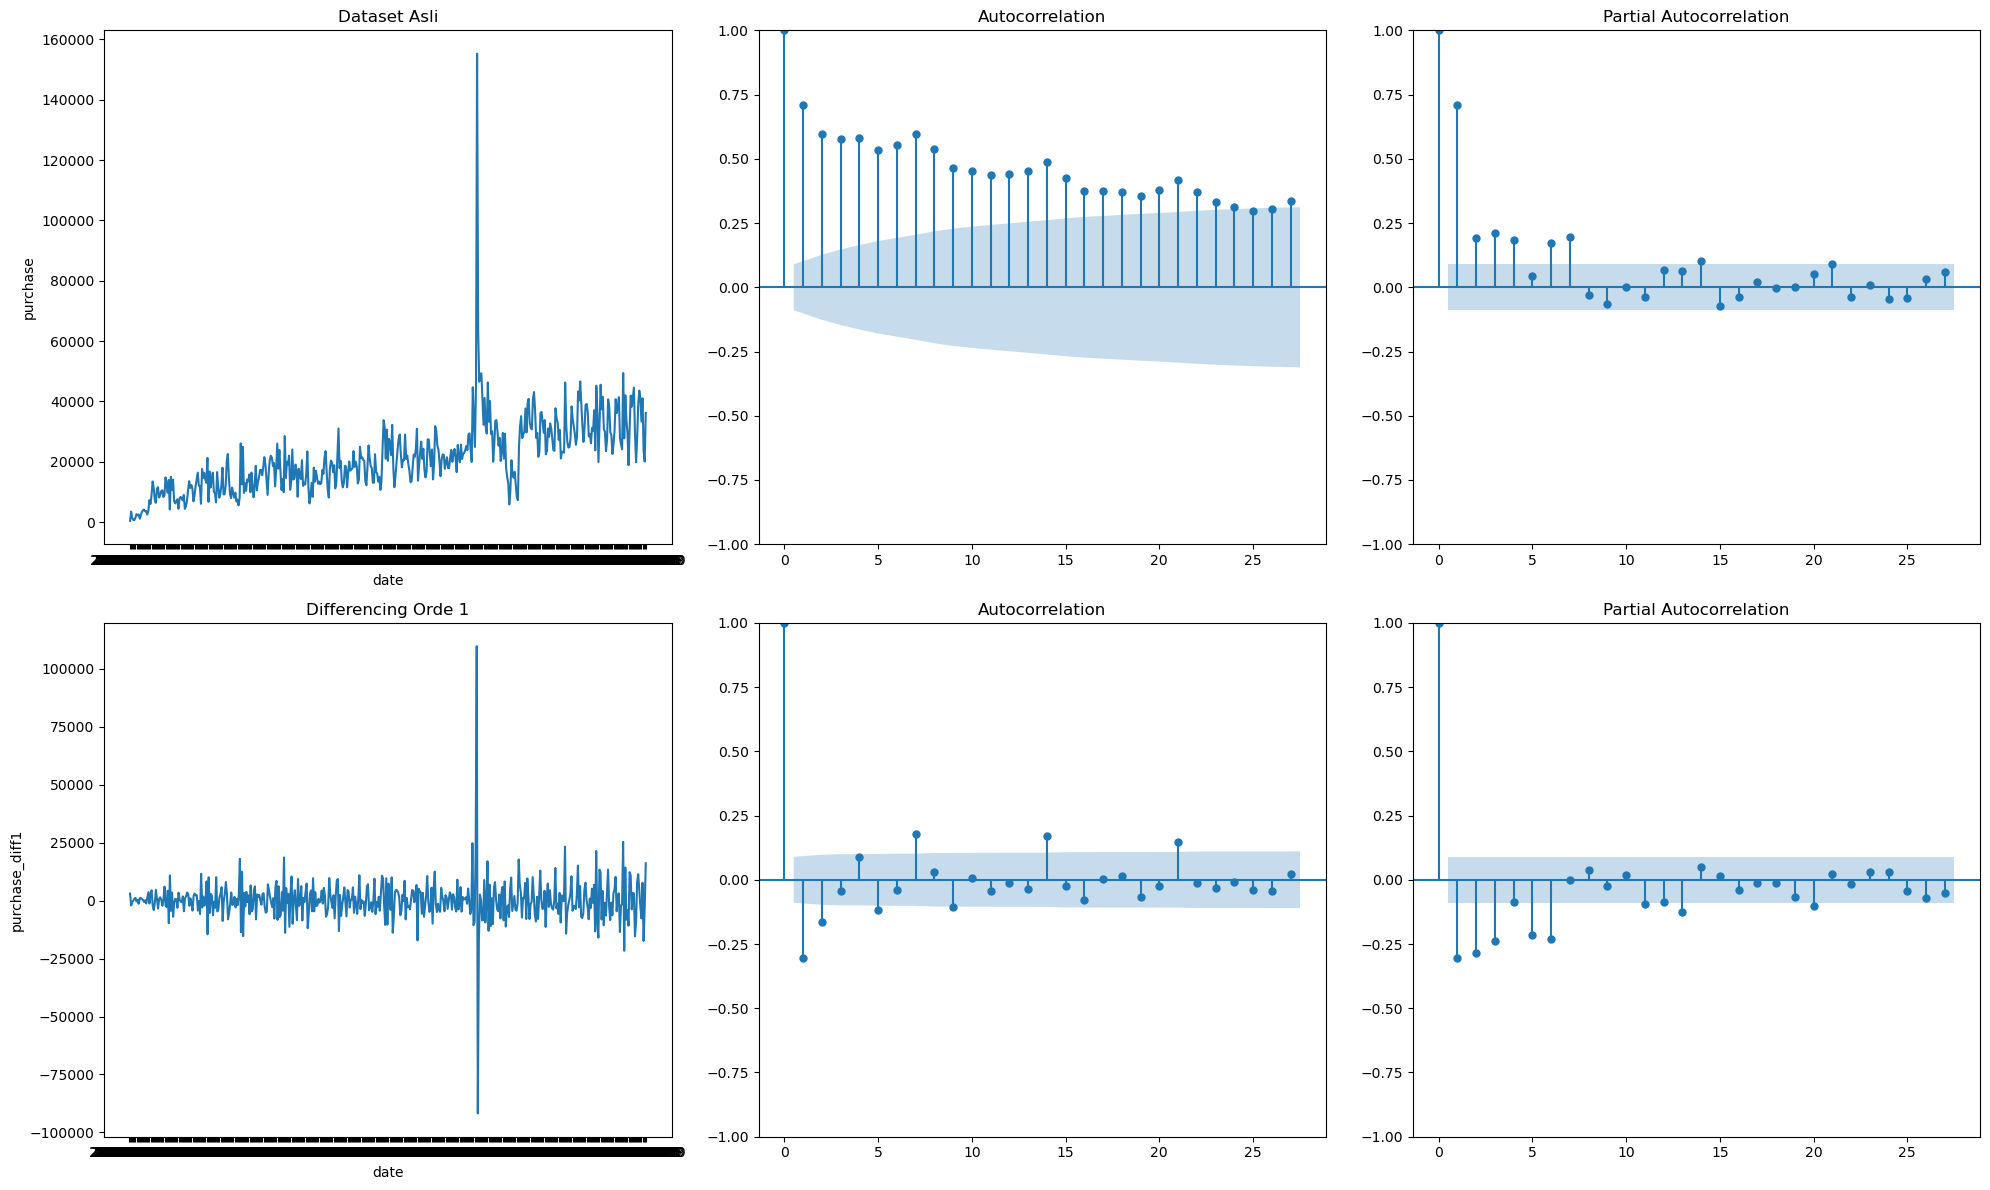

In [92]:
# Membuat grafik ACF dan PACF
# Mempersiapkan data untuk membuat grafik
data_train['purchase_diff1'] = data_train['purchase'].diff()
data_train_temporarily = data_train.copy()
data_train_temporarily['date'] = data_train_temporarily['date'].astype(str)

fig, axes = plt.subplots(2, 3, figsize=(20,12))

# Data asli
sns.lineplot(data=data_train_temporarily, x='date', y='purchase', ax= axes[0, 0])
axes[0,0].set_title('Dataset Asli')
plot_acf(data_train['purchase'], ax=axes[0, 1])
plot_pacf(data_train['purchase'], ax=axes[0, 2])

# Differencing data 1 kali
sns.lineplot(data=data_train_temporarily, x='date', y='purchase_diff1', ax= axes[1, 0])
axes[1,0].set_title('Differencing Orde 1')
plot_acf(data_train['purchase_diff1'].dropna(), ax=axes[1, 1])
plot_pacf(data_train['purchase_diff1'].dropna(), ax=axes[1, 2])

plt.tight_layout()
plt.show()

In [93]:
# Mencari kombinasi p dan q terbaik
# d=1 karena data sudah stasioner setelah dilakukan differencing 1 kali

list_p = list(range(0,15)) # AR
list_q = list(range(0,15)) # MA

list_pdq = []
list_mape = []

for p in list_p:
    for q in list_q:
        list_pdq.append((p,1,q))

        model_loop = ARIMA(y_train, order=(p,1,q))
        model_loop_fit = model_loop.fit()

        y_pred_daily = model_loop_fit.forecast(len(y_test))
        y_pred_daily = y_pred_daily.values

        data_test['pred'] = y_pred_daily
        df_pred_monthly = data_test.groupby(by='month').sum()[['purchase', 'pred']].reset_index()

        mean_absolute_percentage_error=metrics.mean_absolute_percentage_error(df_pred_monthly['purchase'], df_pred_monthly['pred']) 
        mape_score = round(mean_absolute_percentage_error,4)

        list_mape.append(mape_score)

In [94]:
# Membuat dataframe kombinasi pdq dan nilai AIC dengan mengurutkan dari nilai AIC terbaik
df_temp = pd.DataFrame({'p,d,q': list_pdq, 'mape':list_mape}).sort_values('mape')
df_temp

,"p,d,q",mape
156,"(10, 1, 6)",0.0268
30,"(2, 1, 0)",0.0322
45,"(3, 1, 0)",0.0423
60,"(4, 1, 0)",0.0434
216,"(14, 1, 6)",0.0459
...,...,...
55,"(3, 1, 10)",0.1002
42,"(2, 1, 12)",0.1015
154,"(10, 1, 4)",0.1475
0,"(0, 1, 0)",0.1849


In [95]:
# Mengubah value dari kolom 'month' agar memiliki format year-month
df_pred_monthly['month'] = ['2018-05', '2018-06', '2018-07', '2018-08']
df_pred_monthly

,month,purchase,pred
0,2018-05,1021997.47,1.009554e+06
1,2018-06,904962.20,9.742425e+05
2,2018-07,902543.59,1.020805e+06
3,2018-08,874349.63,9.504266e+05


Berdasarkan  hasil dari penentuan model ARIMA, didapatkan bahwa kombinasi p,d,q terbaik yaitu ARIMA (10,1,6) dengan nilai MAPE=0.0268. Oleh karena itu, kami menggunakan model ARIMA dengan MAPE terendah yaitu `ARIMA (10,1,6)`.

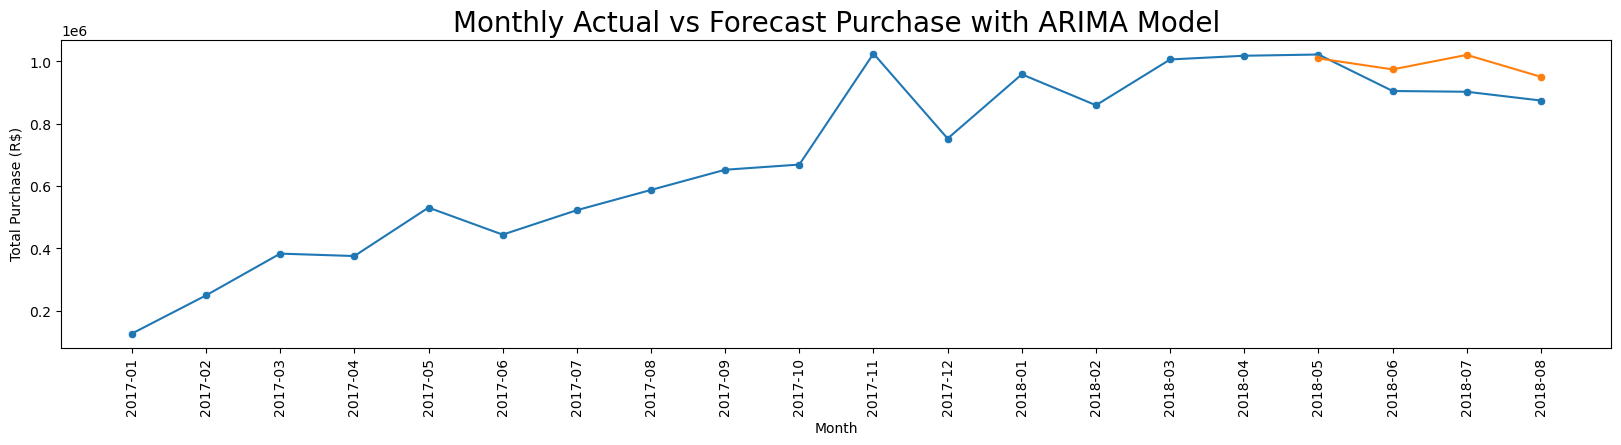

In [96]:
# Membuat grafik untuk melihat perbandingan data aktual dan data prediksi 
plt.figure(figsize = (20,4))

# Purchase Aktual
df_original_series = df_ym.copy()
df_original_series['date'] = df_original_series['date'].astype(str)
sns.lineplot(data = df_original_series, x='date', y='purchase')
sns.scatterplot(data = df_original_series, x='date', y='purchase')

# Purchase Prediksi
sns.lineplot(data = df_pred_monthly, x='month', y='pred')
sns.scatterplot(data = df_pred_monthly, x='month', y='pred')

plt.xticks(rotation = 90)
plt.title('Monthly Actual vs Forecast Purchase with ARIMA Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

### Enet Regression Model

Logistic Regression bekerja dengan mencari Mean Squared Error terkecil, perbedaannya dengan Ridge, Regression, dan Elastic Net hasil Mean Squared Error tersebut diberikan penalti

Ridge dan Regression sebenernya bekerja hampir mirip, keduanya bekerja dengan memberi penalti dari sebuah feature yang menyebabkan dampak feature tersebut berkurang hanya saja pada Ridge dampak feature hanya berkurang tapi tidak sampai 0 sedangkan pada Lasso dampak feature bisa berkurang sampai 0 (dihilangkan/tidak dianggap), Elastic Net bekerja dengan menjumlahkan hasil Ridge + Lambda

Ridge mempunyai rumus Mean Squared Error + Lambda*sum((slope)**2)
Lasso mempunyai rumus Mean Squared Error + Lambda*sum(abs(slope))
Enet mempunyai rumus  Mean Squared Error + Lambda*sum((slope)**2) + Lambda*sum(abs(slope))

Tentukan model, scaler, dan k-fold yang ingin dipakai

In [97]:
models = []
models.append(('linreg', LinearRegression()))
models.append(('ridge', Ridge()))
models.append(('lasso', Lasso()))
models.append(('enet', ElasticNet()))

scaler = StandardScaler()

# Kita mencoba looping n_splits dengan [3,4,5,6] dan 4 memiliki rata-rata error terkecil
tscv = TimeSeriesSplit(n_splits=4)

In [98]:
# Membandingkan performa dari beberapa model yang diberikan
# Dan memilih model dengan nilai MAPE terkecil sebagai model terbaik untuk prediksi pada dataset yang diberikan.

for name, model in models:

  pipe_model = Pipeline([
                       ('scaler',scaler),
                       ('model',model),
  ])

  cv_score = cross_val_score(
      estimator = pipe_model,
      X = X_train,
      y = y_train,
      cv = tscv,
      scoring = 'neg_mean_absolute_percentage_error',
      n_jobs = -1
  )

  print(name, cv_score.mean(),f'({cv_score.std()})')

linreg -0.33257066174554456 (0.13421346152161018)
ridge -0.3301876538117312 (0.13269416090758596)
lasso -0.33246078038656923 (0.13416373511074325)
enet -0.2718496506654624 (0.09254298244197795)


In [99]:
model_candicate = ElasticNet(random_state=10)

# Hypertuning Elastic Net
param_search = {
    'model__alpha' : [1000,100,10,1,0.1,0.01,0.001],
    'model__max_iter' : range(1000,2000,500),
    'model__l1_ratio' : np.arange(0, 1, 0.01),
    'scaler' : [None, MinMaxScaler(), StandardScaler()],
}

model_candicate.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [100]:
# Menentukan model terbaik dengan parameter terbaik menggunakan Grid Search
pipe_model = Pipeline([
                    ('scaler',scaler),
                    ('model', model_candicate),
])

bestsearch = GridSearchCV(
    estimator = pipe_model,
    cv = tscv,
    param_grid = param_search,
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1,
    # error_score='raise'
)

bestsearch.fit(X_train, y_train)
best_score = bestsearch.best_score_
best_parameter = bestsearch.best_params_
best_model = bestsearch.best_estimator_

print(best_score, best_parameter)

-0.2717690820556622 {'model__alpha': 1, 'model__l1_ratio': 0.46, 'model__max_iter': 1000, 'scaler': StandardScaler()}


Setelah prediksi ke y_test ternyata akurasi harian mengalami overfitting, tapi secara grafik persebaran errornya menyebar rata.

Setelah kita coba groupby perbulan ternyata akurasinya jadi lebih baik, karena prediksi TIV akan lebih mudah dipahami secara perbulan, akhirnya kita memilih menilai akurasi model setelah digrupby perbulan.

Grafik yang dihasilkan enet juga jauh lebih baik dari prophet dan arima

In [101]:
# Error Harian
best_model.fit(X_train, y_train)
y_pred_tuned = best_model.predict(X_test)
regression_results(y_test, y_pred_tuned)

MAE:  8503.1874
MAPE:  0.5932
MSE:  120657953.589
RMSE:  10984.4414


In [102]:
# Error bulanan
data_test = df_ymd[(df_ymd['date']>=date_split) & (df_ymd['date']<'2018-09')]

data_test.insert(len(data_test.columns),column='pred',value=y_pred_tuned)
df_support = data_test.groupby(by='month').sum()['pred'].reset_index()

data_pred = df_ym[(df_ym['date']>=date_split) & (df_ym['date']<'2018-09')].copy()
data_pred['pred'] = list(df_support['pred'])

enet_metrics = regression_results(data_pred['purchase'], data_pred['pred'])
enet_metrics

MAE:  54773.1019
MAPE:  0.0575
MSE:  4448500436.0361
RMSE:  66697.0797


Perbandingan grafik *actual* vs prediksi dari 4 bulan terakhir

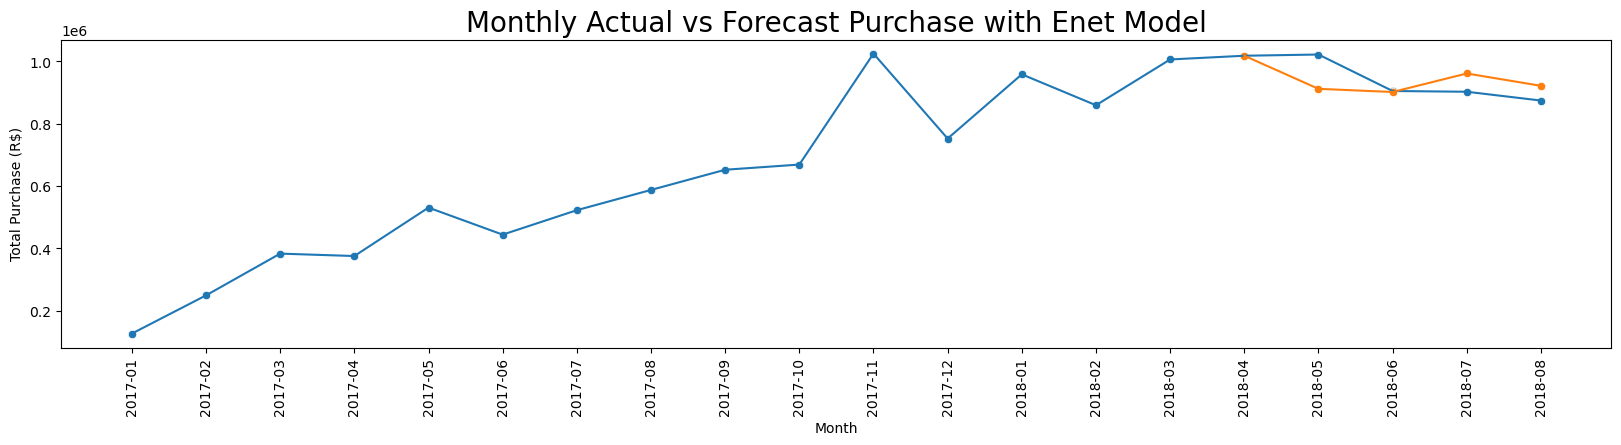

In [103]:
# Membuat grafik untuk melihat perbandingan data aktual dan data prediksi 

plt.figure(figsize = (20,4))

# Purchase Aktual
df_support = df_ym.copy()
df_support['date'] = df_support['date'].astype(str)
sns.lineplot(data = df_support, x='date', y='purchase')
sns.scatterplot(data = df_support, x='date', y='purchase')

# Purchase Prediksi
df_support2 = df_ym[df_ym['date']==min(data_pred['date']) - 1].copy()
df_support2.rename(columns={'purchase':'pred'},inplace=True)
df_support2 = pd.concat([df_support2,data_pred[['date','pred']]])
df_support2['date'] = df_support2['date'].astype(str)
sns.lineplot(data = df_support2, x='date', y='pred')
sns.scatterplot(data = df_support2, x='date', y='pred')

plt.xticks(rotation = 90)
plt.xticks(range(len(df_support)))
plt.title('Monthly Actual vs Forecast Purchase with Enet Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

Elastic Net Regression adalah salah satu jenis teknik regresi yang digunakan untuk memodelkan hubungan antara satu atau lebih variabel prediktor (variabel independen) dengan variabel target (variabel dependen).

Elastic Net Regression adalah kombinasi dari dua jenis regresi, yaitu Ridge Regression dan Lasso Regression. Ridge Regression digunakan untuk mengurangi overfitting, sedangkan Lasso Regression digunakan untuk melakukan seleksi fitur. Dalam Elastic Net Regression, kedua teknik ini digabungkan untuk menghasilkan model yang lebih stabil dan memiliki performa yang lebih baik.

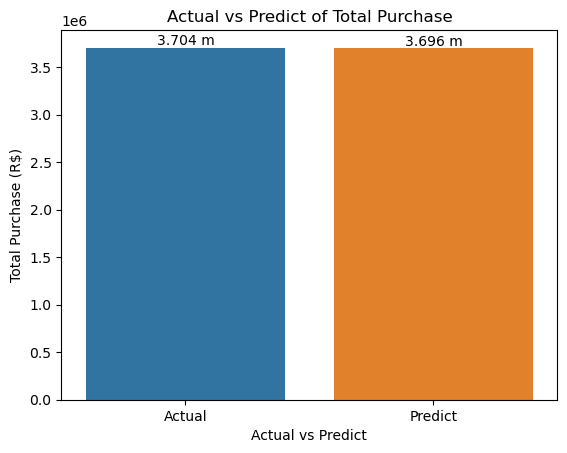

In [104]:
# Membuat grafik untuk membandingkan total purchase pada data aktual vs data prediksi
total_test_actual = data_pred['purchase'].sum()
total_test_predict = data_pred['pred'].sum()

df_support = pd.DataFrame({
    'Actual': [total_test_actual],
    'Predict': [total_test_predict],
})

ax = sns.barplot(data=df_support)

for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 3)} m'  for h in bar.datavalues])

ax.set(xlabel='Actual vs Predict', ylabel='Total Purchase (R$)',
       title='Actual vs Predict of Total Purchase')

plt.show()

In [105]:
# Actual Error dan Percentage Error
percentage_error = round(abs(total_test_actual - total_test_predict)/total_test_actual*100,2)
print(f'actual_error : {round(total_test_actual - total_test_predict,2)}')
print(f'percentage_error : {percentage_error}%')

actual_error : 7375.28
percentage_error : 0.2%


## **Predict ke Case Asli**

### Dengan menggunakan ARIMA

In [106]:
# Membuat model ARIMA menggunakan parameter terbaik (p,d,q)
model = ARIMA(df_ymd['purchase'], order = (10, 1, 6))
model_arima = model.fit()

In [107]:
# Melakukan prediksi 124 hari, yaitu dari tanggal 30 Agustus 2018 sampai tanggal 31 Desember 2018
forecast_length = 124

forecast_result = model_arima.forecast(forecast_length)
forecast_result = forecast_result.values

forecast_result

array([ 7489.16954314,  4593.18716709,  5484.38817485,  8823.29855706,
       14971.96835512, 19541.2342366 , 19248.60815186, 17906.32402691,
       16013.53564007, 14812.10161752, 18319.60187959, 22221.09883644,
       25033.20956864, 25674.23745247, 22565.45195161, 19891.38611354,
       19450.61275766, 21082.70194318, 25277.62327667, 27682.92997564,
       27203.47261218, 24868.86056655, 21526.81956699, 20722.8405586 ,
       22941.67138676, 25979.55194017, 28637.34691252, 28144.36115948,
       25202.2008108 , 22494.88492619, 21392.97826682, 23292.05491372,
       26726.18895524, 28672.31824543, 28383.13287842, 25608.39069874,
       22570.47701461, 21881.23306136, 23586.93713208, 26712.33134518,
       28932.56531903, 28257.90676268, 25675.13317951, 22847.84965362,
       21929.557419  , 23828.61433219, 26795.03781861, 28770.85029359,
       28336.71614359, 25599.46892187, 22929.44644506, 22160.50287184,
       23841.05602264, 26853.1490381 , 28729.19653194, 28165.61942793,
      

In [108]:
# Membuat tanggal yang ingin diprediksi
i = 0
list_date = []

while i < forecast_length:
    i += 1
    list_date.append(df_ymd['date'].iloc[-1]+i)

list_date

[Period('2018-08-30', 'D'),
 Period('2018-08-31', 'D'),
 Period('2018-09-01', 'D'),
 Period('2018-09-02', 'D'),
 Period('2018-09-03', 'D'),
 Period('2018-09-04', 'D'),
 Period('2018-09-05', 'D'),
 Period('2018-09-06', 'D'),
 Period('2018-09-07', 'D'),
 Period('2018-09-08', 'D'),
 Period('2018-09-09', 'D'),
 Period('2018-09-10', 'D'),
 Period('2018-09-11', 'D'),
 Period('2018-09-12', 'D'),
 Period('2018-09-13', 'D'),
 Period('2018-09-14', 'D'),
 Period('2018-09-15', 'D'),
 Period('2018-09-16', 'D'),
 Period('2018-09-17', 'D'),
 Period('2018-09-18', 'D'),
 Period('2018-09-19', 'D'),
 Period('2018-09-20', 'D'),
 Period('2018-09-21', 'D'),
 Period('2018-09-22', 'D'),
 Period('2018-09-23', 'D'),
 Period('2018-09-24', 'D'),
 Period('2018-09-25', 'D'),
 Period('2018-09-26', 'D'),
 Period('2018-09-27', 'D'),
 Period('2018-09-28', 'D'),
 Period('2018-09-29', 'D'),
 Period('2018-09-30', 'D'),
 Period('2018-10-01', 'D'),
 Period('2018-10-02', 'D'),
 Period('2018-10-03', 'D'),
 Period('2018-10-04'

In [109]:
# Membuat dataframe dari data hasil prediksi
df_forecast = pd.DataFrame({
    'date': list_date,
    'purchase': forecast_result
})

df_forecast[df_forecast['date']>'2018-08-29']

,date,purchase
0,2018-08-30,7489.169543
1,2018-08-31,4593.187167
2,2018-09-01,5484.388175
3,2018-09-02,8823.298557
4,2018-09-03,14971.968355
...,...,...
119,2018-12-27,25390.179914
120,2018-12-28,23481.305798
121,2018-12-29,23109.666486
122,2018-12-30,24543.843081


In [110]:
# Menggabungkan data aktual dengan data prediksi
df_concat = pd.concat([df_ymd, df_forecast[df_forecast['date']>'2018-08-29']])[['date', 'purchase']]
df_concat

,date,purchase
0,2017-01-05,396.900000
1,2017-01-06,3460.380000
2,2017-01-07,1351.900000
3,2017-01-08,709.580000
4,2017-01-09,673.790000
...,...,...
119,2018-12-27,25390.179914
120,2018-12-28,23481.305798
121,2018-12-29,23109.666486
122,2018-12-30,24543.843081


In [111]:
# Mempersiapkan data untuk dikelompokan berdasarkan bulan
df_concat['date'] = df_concat['date'].astype(str)
df_concat['date'] = pd.to_datetime(df_concat['date'])

df_concat['month'] = df_concat['date'].dt.to_period('M')

In [112]:
# Mengelompokan data berdasarkan bulan
df_month = df_concat.groupby(by='month').sum()[['purchase']].reset_index().sort_values(by='month', ascending=True)
df_month

,month,purchase
0,2017-01,1.267208e+05
1,2017-02,2.493293e+05
2,2017-03,3.832839e+05
3,2017-04,3.755314e+05
4,2017-05,5.308884e+05
5,2017-06,4.441941e+05
6,2017-07,5.226081e+05
7,2017-08,5.875506e+05
8,2017-09,6.523536e+05
9,2017-10,6.689536e+05


In [113]:
# Membagi data aktual dan data prediksi untuk memudahkan melakukan visualisasi data
df_month_final = df_month.iloc[:20]
df_forecast = df_month.iloc[19:].reset_index()

display(df_month_final, df_forecast)

,month,purchase
0,2017-01,1.267208e+05
1,2017-02,2.493293e+05
2,2017-03,3.832839e+05
3,2017-04,3.755314e+05
4,2017-05,5.308884e+05
5,2017-06,4.441941e+05
6,2017-07,5.226081e+05
7,2017-08,5.875506e+05
8,2017-09,6.523536e+05
9,2017-10,6.689536e+05


,index,month,purchase
0,19,2018-08,886431.986710
1,20,2018-09,636407.356136
2,21,2018-10,796229.753776
3,22,2018-11,762582.490614
4,23,2018-12,788349.118045


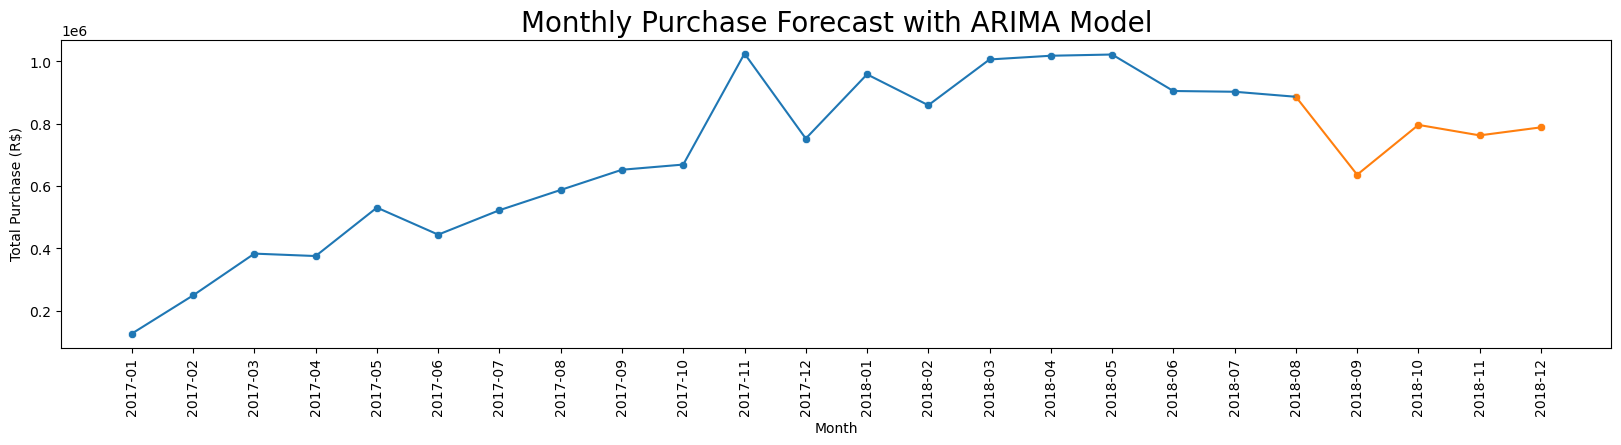

In [114]:
# Melakukan visualisasi data menggunakan lineplot
# Data prediksi berwarna oranye
plt.figure(figsize = (20,4))

# Actual Purchase
df_temp_actual = df_month_final.copy()
df_temp_actual['month'] = df_temp_actual['month'].astype(str)
actual = sns.lineplot(data = df_temp_actual, x='month', y='purchase')
sns.scatterplot(data = df_temp_actual, x='month', y='purchase')

# Forecast Purchase
df_temp_forecast = df_forecast.copy()
df_temp_forecast['month'] = df_temp_forecast['month'].astype(str)
forecast = sns.lineplot(data = df_temp_forecast, x='month', y='purchase')
sns.scatterplot(data = df_temp_forecast, x='month', y='purchase')

plt.xticks(rotation = 90)
plt.title('Monthly Purchase Forecast with ARIMA Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

### Dengan menggunakan Enet

In [115]:
df_support = pd.DataFrame(columns=['date'])
future_months = 4
i = 0

while i < future_months :
    i += 1
    df_support.loc[len(df_support)] = max(data_pred['date'])+i

df_support['year'] = df_support['date'].dt.year
df_support['month'] = df_support['date'].dt.month
df_support['day'] = df_support['date'].dt.day

future_days = df_support['day'].sum()
year = df_support['year'][0]
month = df_support['month'][0]
day = 1

df_future_month = df_support.copy()
df_support = pd.DataFrame(columns=['date'])

for i in range(0,future_days):
    df_support.loc[len(df_support)] = datetime(year, month, day) + timedelta(days=i)

df_future = df_support.copy()

# Membuat dataframe untuk real case
df_future['year'] = df_future['date'].dt.year
df_future['month'] = df_future['date'].dt.month
df_future['day'] = df_future['date'].dt.day
df_future['weekday'] = df_future['date'].dt.weekday

# Menambahkan feature black friday
df_future['black_friday'] = (df_future['month']==11) & (df_future['day'].between(23,28))
df_future['black_friday'] = np.where(df_future['black_friday'] == True, 1, 0)

# Define seluruh data set sebagai train set dan dataframe real case sebagai test set

X_train = df_ymd[['year','month','day','weekday','black_friday']]
y_train = df_ymd['purchase']
X_test = df_future[['year','month','day','weekday','black_friday']]

# Fit train set dan predict test set
best_model.fit(X_train, y_train)
y_pred_tuned = best_model.predict(X_test)

# Grafik prediksi real case
df_future.insert(len(df_future.columns),column='pred',value=y_pred_tuned)
df_support = df_future.groupby(by=['year','month']).sum()['pred'].reset_index()

df_future_month.insert(len(df_future_month.columns),column='pred',value=df_support['pred'])
df_future_month

,date,year,month,day,pred
0,2018-09,2018,9,30,9.196376e+05
1,2018-10,2018,10,31,9.786085e+05
2,2018-11,2018,11,30,1.145017e+06
3,2018-12,2018,12,31,1.009539e+06


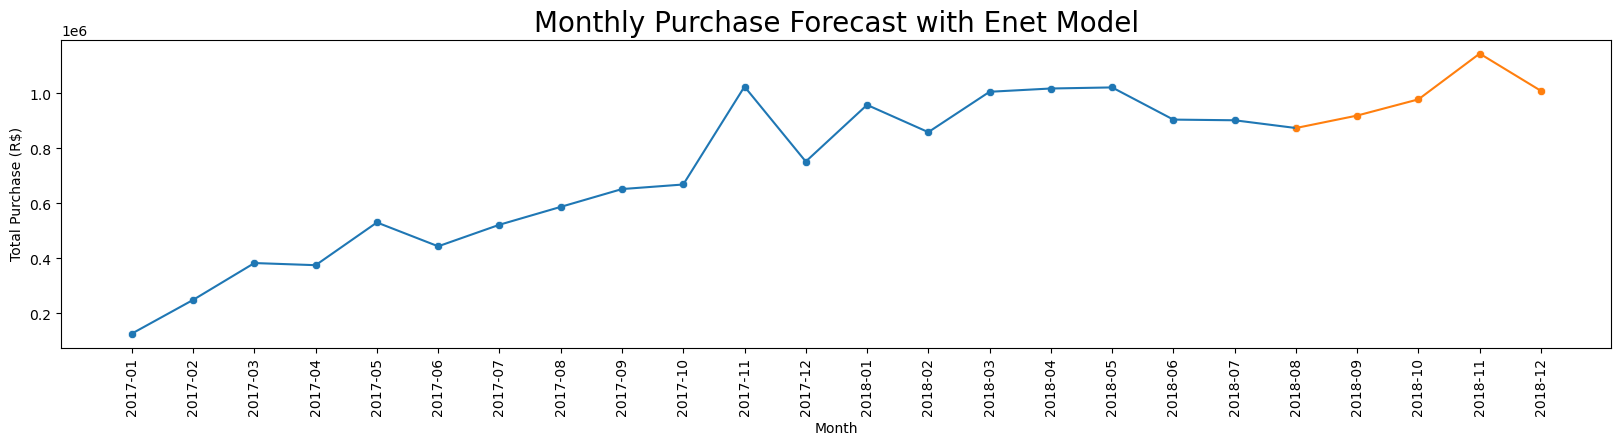

In [116]:
# Membuat grafik untuk melihat hasil prediksi menggunakan Enet Model 
df_support = df_ym.copy()
df_support['date'] = df_support['date'].astype(str)

df_support2 = df_future_month[['date','pred']].copy()
df_support2 = pd.concat([
    df_support.iloc[[-1]].rename(columns={'purchase':'pred'}),
    df_support2
    ])
df_support2['date'] = df_support2['date'].astype(str)

plt.figure(figsize = (20,4))

# Purchase Aktual
sns.lineplot(data = df_support, x='date', y='purchase')
sns.scatterplot(data = df_support, x='date', y='purchase')

# Purchase Prediksi
sns.lineplot(data = df_support2, x='date', y='pred')
sns.scatterplot(data = df_support2, x='date', y='pred')
    
plt.xticks(rotation = 90)
plt.title('Monthly Purchase Forecast with Enet Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

In [117]:
total_pred_tiv = df_future_month['pred'].sum()
print(f'Total prediksi TIV untuk {future_months} bulan kedepan berkisar {round(total_pred_tiv,2)} R$')

Total prediksi TIV untuk 4 bulan kedepan berkisar 4052801.79 R$


Pada akhirnya kami lebih merekomendasikan model enet dibanding arima karena setelah dites ke real case prediksi menggunakan enet terlihat lebih bisa diterima dibanding arima. Apalagi pada bulan November enet memprediksi terjadi kelonjakan yang sepertinya disebabkan oleh Black Friday seperti bulan November tahun lalu

Dari angka ini kita bisa menentukan budget marketing yang diperlukan. Salah satu caranya bisa menggunakan benchmark performa marketing kita dari periode sebelumnya, contohnya:

Jika performa kita di periode sebelumnya bisa memperoleh TIV **16 R$** dengan budget marketing **4 R$**<br>
berarti jika diperiode ini **prediksi** TIV **20 R$** maka bisa dicapai dengan budget marketing sebesar **5 R$**<br>

note : angka disini cuman contoh, tim marketing mungkin punya pendapat lain

## **Evaluasi Model**

**Siapa yang cocok menggunakan model :**

Model ini cocok digunakan oleh tim marketing agar mendapat gambaran mengenai perkiraan Total Item Value yang bisa didapatkan di masa mendatang. Dari prediksi ini diharapkan bisa membantu tim marketing agar tidak overbudget dalam menentukan budget dan diharapkan bisa membantu menyusun strategi dan kpi yang lebih terukur.

**Limitasi model :**

Karena merupakan time series model ini punya beberapa keterbatasan terutama pada feature yang digunakan hanya tanggal saja dan tidak bisa menggunakan feature lain yang belum pasti terjadi (contohnya volume, di realcase kita tidak tau berapa volume yang akan terjadi). Selain itu pada fbprophet dan arima tidak boleh ada tanggal yang terlewat

Selain itu model ini baru belajar dari 20 bulan (16 train dan 4 test), jika langsung memprediksi secara bulanan maka dari itu kami memilih prediksi harian. Dengan prediksi bulanan model hanya belajar dari 16 baris dan 2 fitur (year, dan month), sedangkan dengan harian dapat belajar dari 480 baris dan 4 fitur (year, month, day, weekday)

Jika melihat prediksi harian di test set maka error cenderung besar karena memang secara natural memprediksi behaviour belanja orang secara harian memang sulit, akan tetapi jika kita melihat big picture melalu bulan atau quarter model ini jadi lebih akurat.

**Improve yang dapat kita lakukan :**

Model menggunakan prediksi harian tapi untuk penilaian kita groupby berdasarkan bulan barulah kita ukur metric-nya, jadi best parameter yang sebenernya diperuntukan untuk prediksi harian bukan bulanan. Kedepannya jika kita mau mendapat best parameter yang diperuntukan bulanan kita bisa membuat script sendiri menggunakan looping.

Selain itu kita bisa melakukan feature engineering, seperti menandai hari-hari yang masuk weekend atau hari besar.


## **Rekomendasi Bisnis**

**Average Basket Size (ABS)**

Rata-rata customer melakukan pembelian dalam sekali check-out

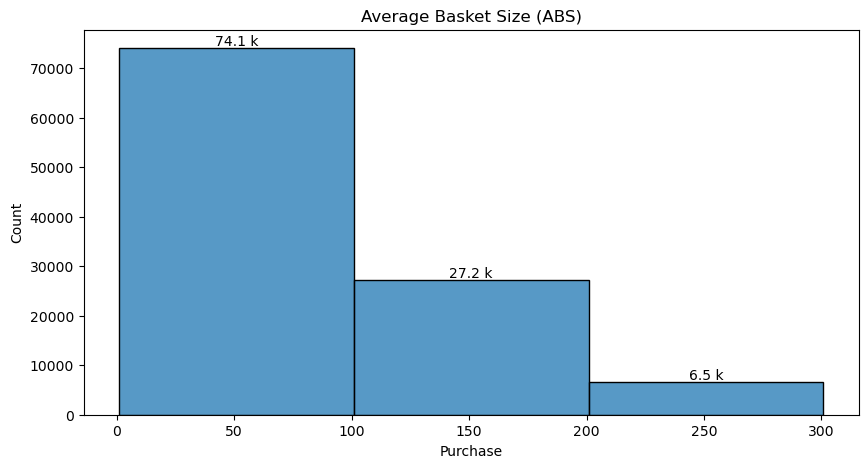

In [118]:
plt.figure(figsize = (10,5))
ax = sns.histplot(data=df_orders[df_orders['purchase']<=300],x='purchase',binwidth=100,kde=False)

# Menambahkan annotate pada setiap bar
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 1)} k'  for h in bar.datavalues])

# Mengatur label axis dan judul
ax.set(xlabel='Purchase', ylabel='Count',
       title='Average Basket Size (ABS)')

plt.show()

#### **Rekomendasi 1** :
Average Basket Size customer senilai 75 R$, bisakah di tahun 2019 kita meningkatkan rata-rata pembelian sampai ke 90 R$, contohnya :

Jika custommer melakukan pembelanjaan minimal 90 R$ akan mendapat voucher senilai 10 R$:

Keuntungan bagi custommer :

    •  Hanya dengan menambah ABS sebesar 15 R$ (dari 75 menjadi 90) bisa mendapat voucher senilai 10 R$

Keuntungan bagi kita :

    •  Karena ini berupa voucher maka customer akan memakainya untuk berbelanja di platform kita lagi
    •  Mengikat customer saat ingin membeli barang akan menggunakan platform kita agar voucher yang dia peroleh tidak sia-sia (membantu meningkatkan retention rate)

Note : angka disini cuman contoh, tim marketing mungkin punya pendapat lain

---

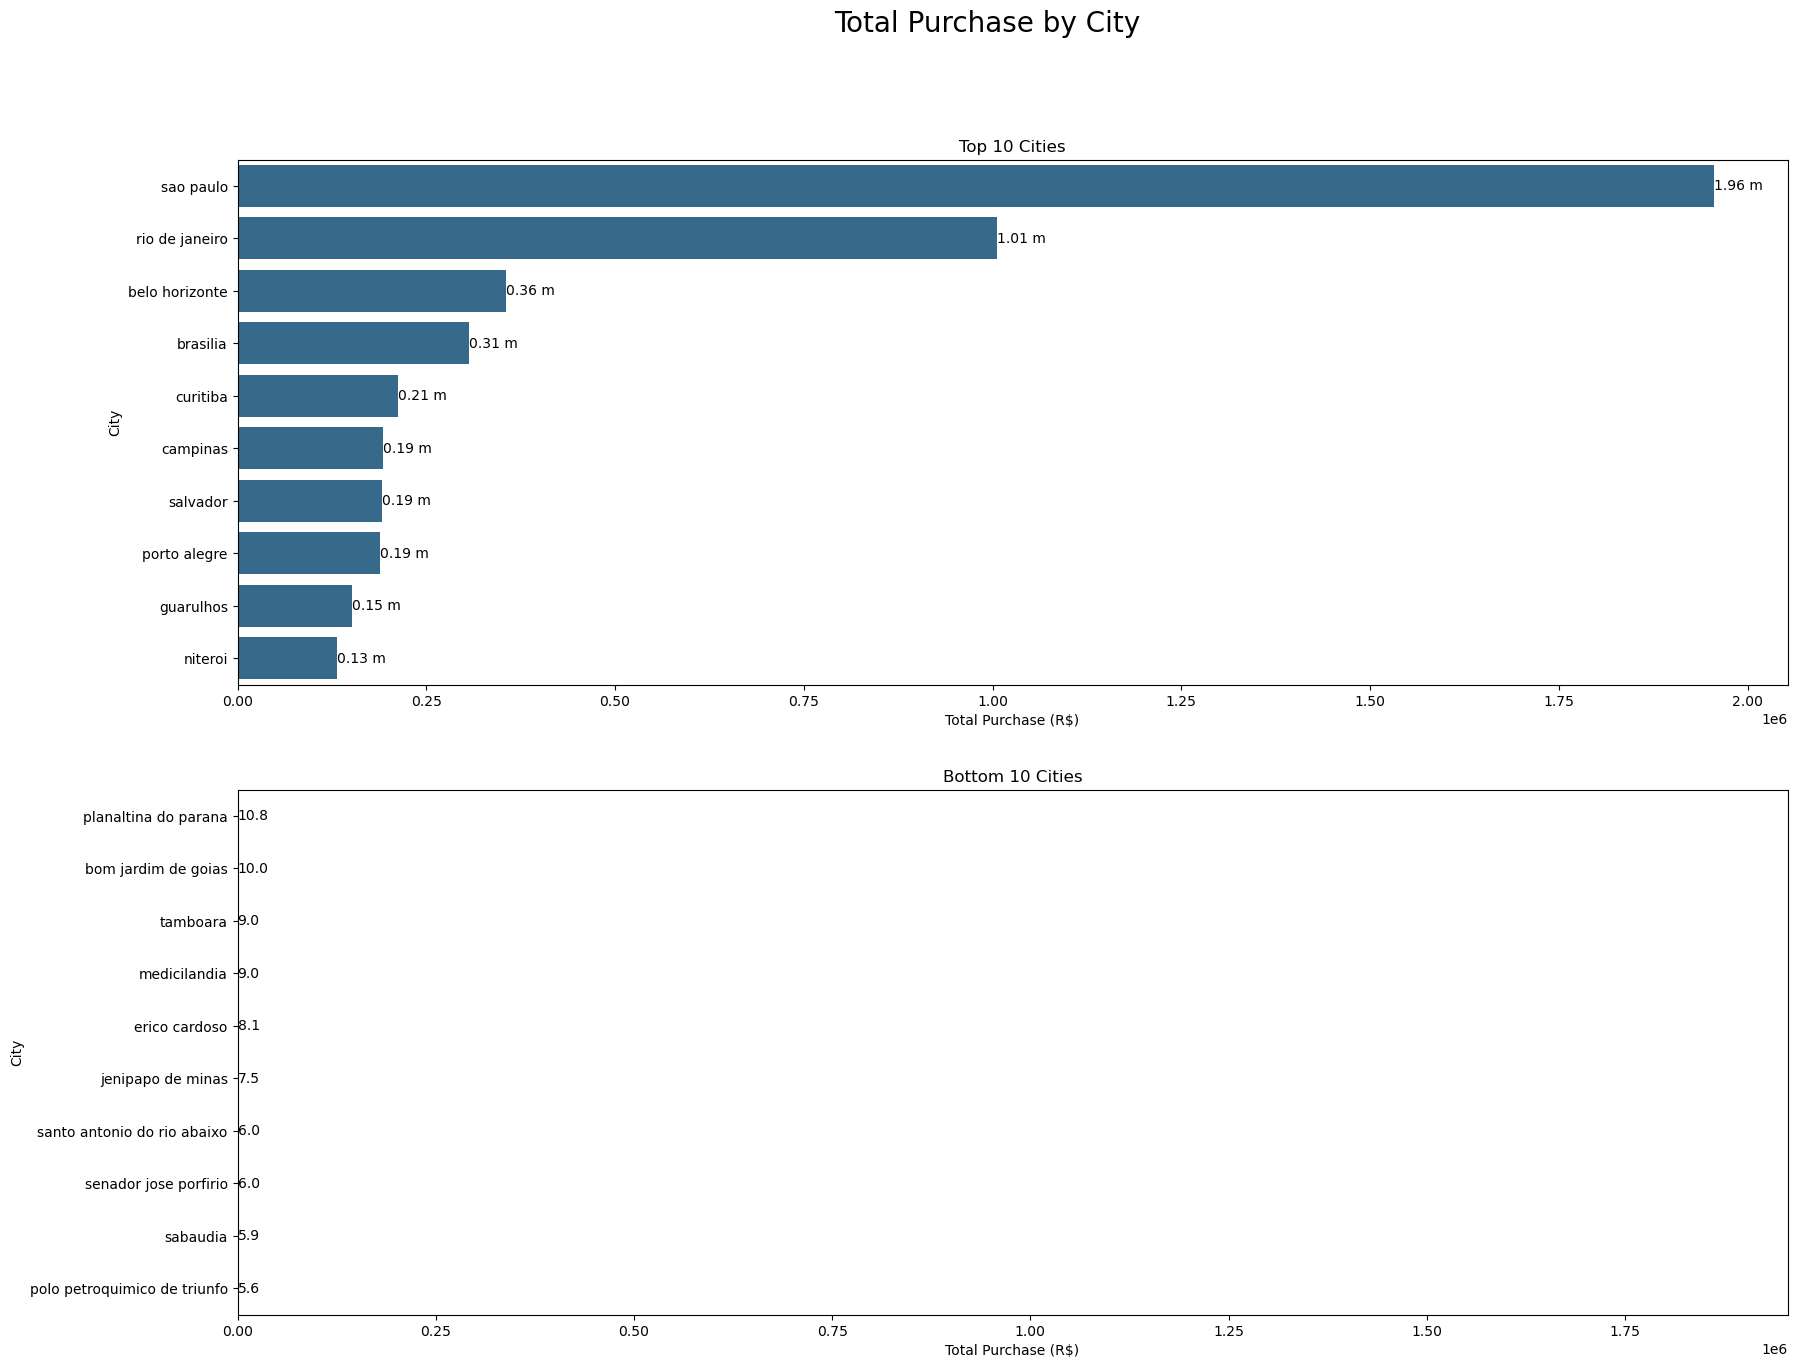

In [119]:
# Top 10 Cities 
df_city = df_orders.groupby(by='customer_city').sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)
df_city_top10 = df_city.head(10)

# Bottom 10 Cities 
df_city_bottom = df_city.tail(10)

# Membuat barplot
plt.figure(figsize = (20,15))

plt.subplot(2,1,1)
top = sns.barplot(data=df_city_top10,x='purchase',y='customer_city',color='#296d98')
top.set(xlabel='Total Purchase (R$)', ylabel='City',
       title='Top 10 Cities')
# Annotate
for i in top.containers:
    top.bar_label(i, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in i.datavalues])

plt.subplot(2,1,2)
bottom = sns.barplot(data=df_city_bottom,x='purchase',y='customer_city',color='#296d98')
bottom.set(xlabel='Total Purchase (R$)', ylabel='City',
       title='Bottom 10 Cities')
# Annotate
for j in bottom.containers:
    bottom.bar_label(j, label_type='edge', labels=[round(h, 1)  for h in j.datavalues])

plt.xlim(0, max(df_city['purchase']))
plt.suptitle('Total Purchase by City', size=20)
plt.show()

In [120]:
df_support = df_orders.groupby(by='customer_city').sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)
df_support2 = df_orders.groupby(by='customer_city').count()[['purchase']].reset_index().sort_values(by='purchase',ascending=False).rename(columns={'purchase':'total_customer'})

df_support['percentage'] = df_support['purchase']/df_support['purchase'].sum()*100
df_support['percent_cumsum'] = df_support['percentage'].cumsum()

df_top_pop_city = pd.DataFrame({
    'customer_city': ['sao paulo', 'rio de janeiro', 'brasilia', 'salvador', 'fortaleza', 'belo horizonte', 'manaus'],
    'population_est_2021': [12396372,6775561,3094325,2900319,2703391,2530701,2255903]
})

df_top_pop_city = df_support.merge(df_top_pop_city,on='customer_city').merge(df_support2,on='customer_city')

print(f'Seluruh jumlah kota : {len(df_support)}\n2 kota teratas menyumbang 21% total penjualan')
df_top_pop_city['acq_rate'] = df_top_pop_city['total_customer']/df_top_pop_city['population_est_2021']*100
df_top_pop_city.head(3)

Seluruh jumlah kota : 4091
2 kota teratas menyumbang 21% total penjualan


,customer_city,purchase,percentage,percent_cumsum,population_est_2021,total_customer,acq_rate
0,sao paulo,1955055.20,14.101095,14.101095,12396372,18097,0.145986
1,rio de janeiro,1005338.38,7.251137,21.352232,6775561,7989,0.117909
2,belo horizonte,355349.28,2.563004,23.915236,2530701,3163,0.124985


Top 3-7 kota dengan populasi terbanyak mempunyai jumlah hampir sama


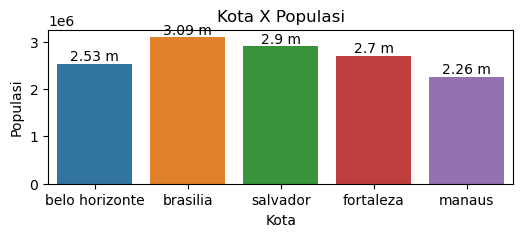

Tapi user acquisition rate masih jauh berbeda


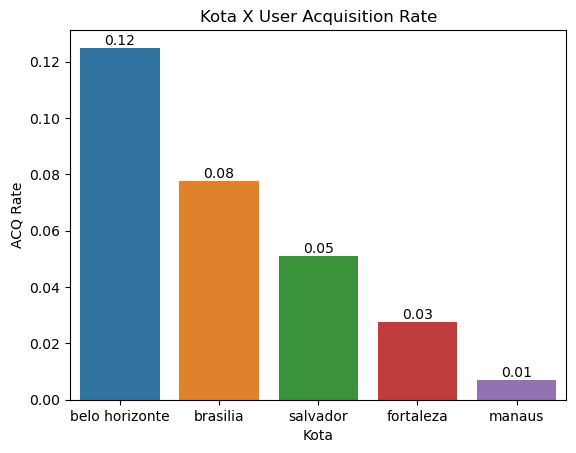

Menyebabkan total purchase juga jauh berbeda


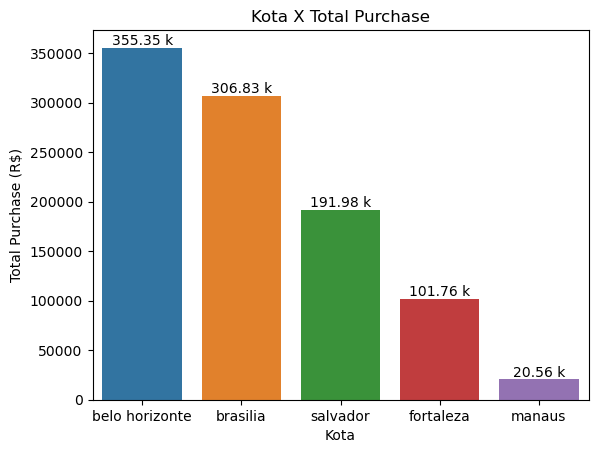

In [121]:
plt.figure(figsize = (6,2))

print('Top 3-7 kota dengan populasi terbanyak mempunyai jumlah hampir sama')
a= sns.barplot(data=df_top_pop_city[2:],x='customer_city',y='population_est_2021')
for bar in a.containers:
    a.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in bar.datavalues])
plt.ylabel('Populasi')
plt.xlabel('Kota')
plt.title('Kota X Populasi')
plt.show()

print('Tapi user acquisition rate masih jauh berbeda')
b= sns.barplot(data=df_top_pop_city[2:],x='customer_city',y='acq_rate')
for bar in b.containers:
    b.bar_label(bar, label_type='edge', labels=[round(h,2)  for h in bar.datavalues])
plt.ylabel('ACQ Rate')
plt.xlabel('Kota')
plt.title('Kota X User Acquisition Rate')
plt.show()

print('Menyebabkan total purchase juga jauh berbeda')
c = sns.barplot(data=df_top_pop_city[2:],x='customer_city',y='purchase')
for bar in c.containers:
    c.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 2)} k'  for h in bar.datavalues])
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Kota')
plt.title('Kota X Total Purchase')
plt.show()


#### **Rekomendasi 2** :
Bisakah kita mengurangi promo di 2 kota teratas dan lebih mengandalkan brand marketing, CRM, Organic tanpa mengurangi Total Item Value kemudian promo dialihkan ke kota lain yang mempunyai potensi pertumbuhan tinggi, seperti :

    •  Brasilia
    •  Salvador
    •  Fortaleza
    •  Manaus

Jika dibanding Belo Horizonte kota-kota diatas mempunyai jumlah populasi yang mirip dengan Belo Horizonte akan tetapi user acquisition rate masih lebih sedikit, menyebabkan total purchase juga lebih sedikit dibanding Belo Horizonte

Kita bisa meningkatkan user acquisiton di kota-kota tersebut dengan beberapa langkah seperti :

    •  Mencoba offline marketing (spanduk, baliho)
    •  Membuat konten marketing dengan kearifan lokal
    •  Memberikan promo khusus bagi new user yang berasal dari kota-kota tersebut

---

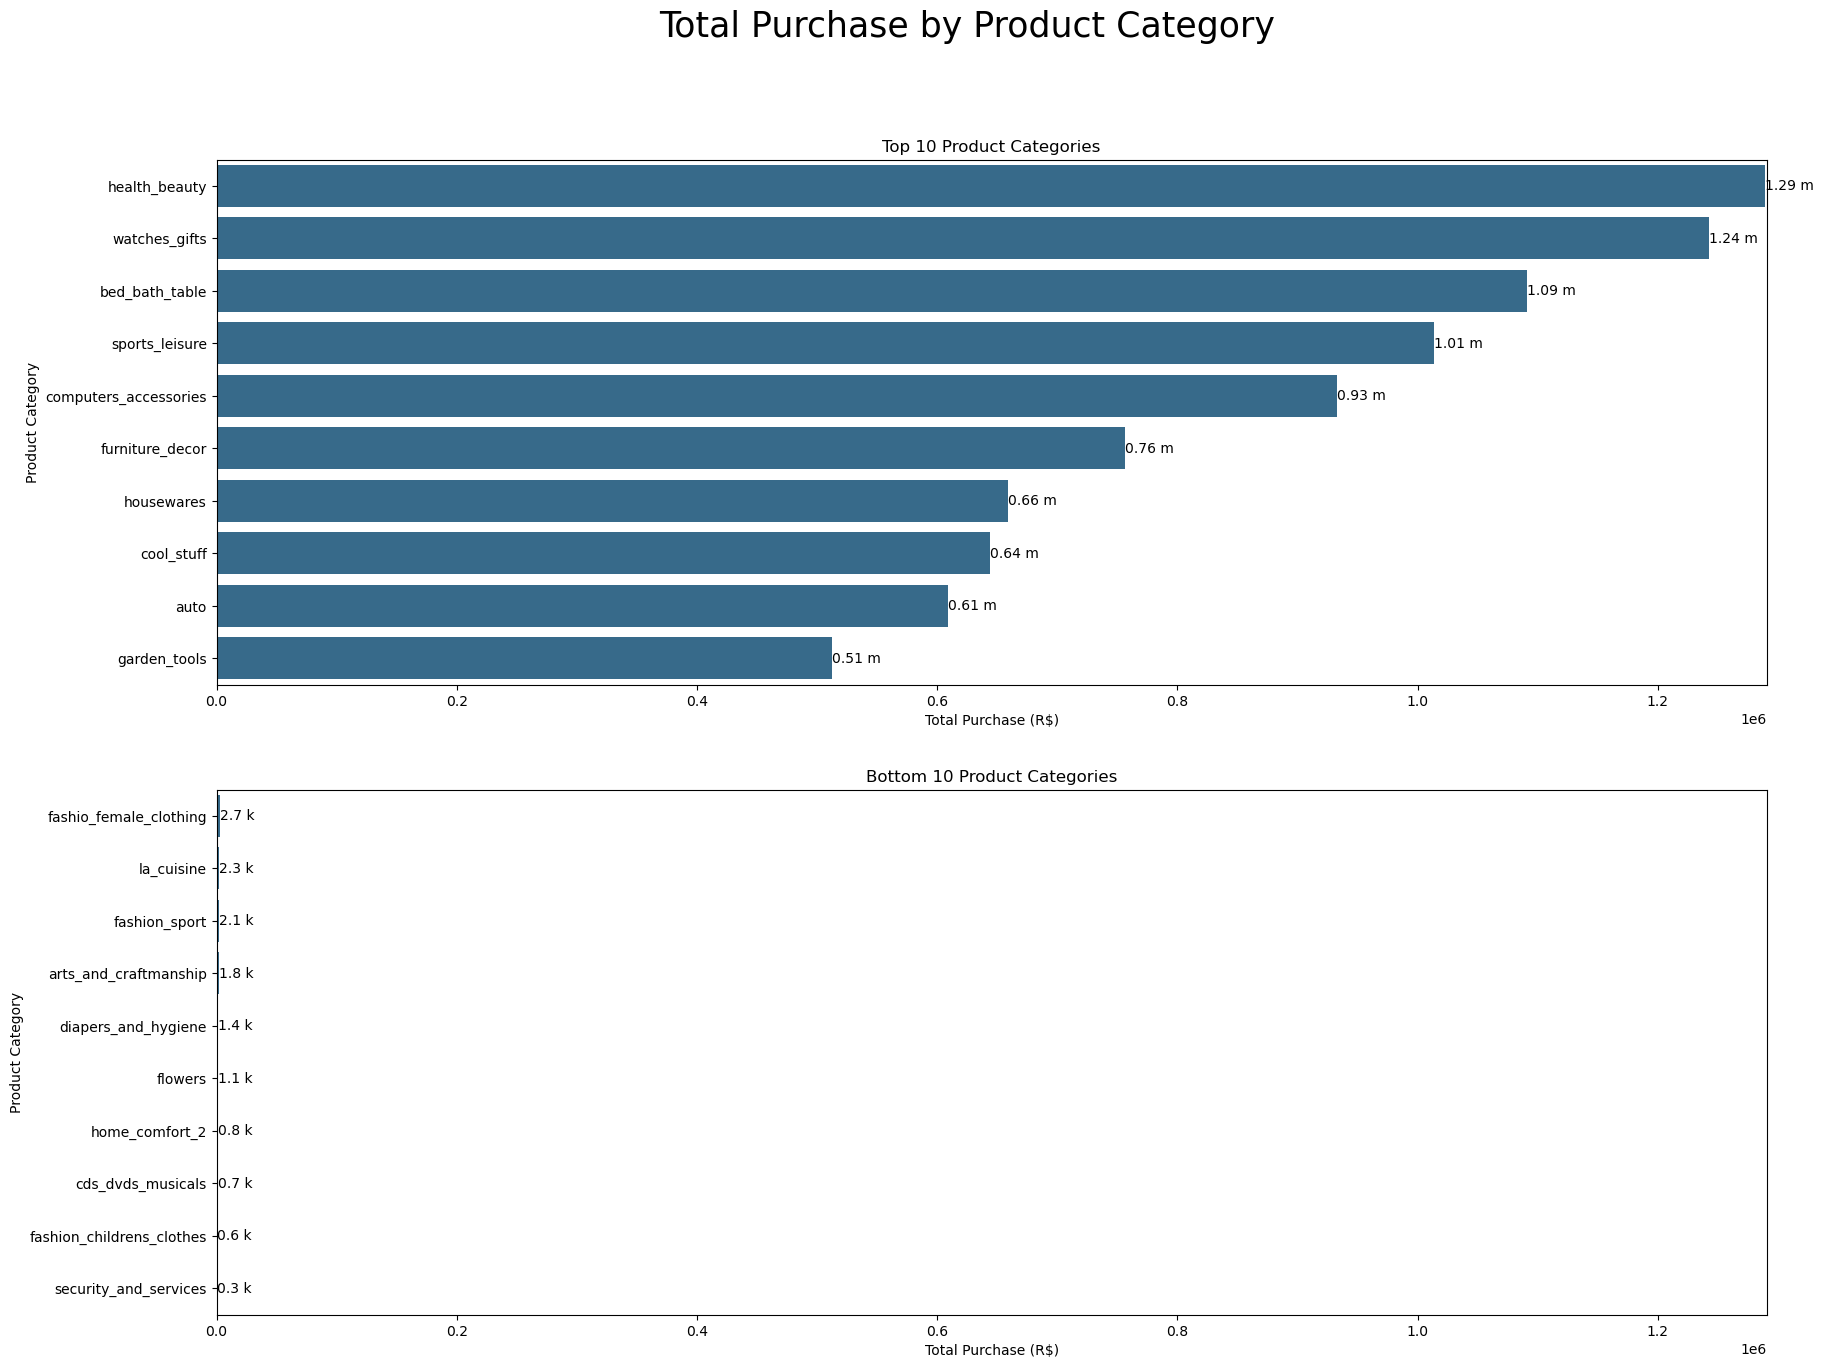

In [122]:
# Top 10 Product Categories
df_product_cat = df_orders.groupby(by='product_category_name_english').sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)
df_product_cat_top10 = df_product_cat.head(10)

# Bottom 10 Product Categories
df_product_cat_bottom = df_product_cat.tail(10)
df_product_cat_bottom

# Membuat barplot
plt.figure(figsize = (20,15))

plt.subplot(2,1,1)
top = sns.barplot(data=df_product_cat_top10, x='purchase', y='product_category_name_english', color='#296d98')
top.set(xlabel='Total Purchase (R$)', ylabel='Product Category',
       title='Top 10 Product Categories')
plt.xlim(0, df_product_cat_top10['purchase'].max() + 1000) 
# Annotate
for i in top.containers:
    top.bar_label(i, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in i.datavalues])

plt.subplot(2,1,2)
bottom = sns.barplot(data=df_product_cat_bottom, x='purchase', y='product_category_name_english', color='#296d98')
bottom.set(xlabel='Total Purchase (R$)', ylabel='Product Category',
       title='Bottom 10 Product Categories')
plt.xlim(0, df_product_cat_top10['purchase'].max() + 1000) 
# Annotate
for j in bottom.containers:
    bottom.bar_label(j, label_type='edge', labels=[f'{round(h/1e3, 1)} k'  for h in j.datavalues])

plt.suptitle('Total Purchase by Product Category', size=25)
plt.show()

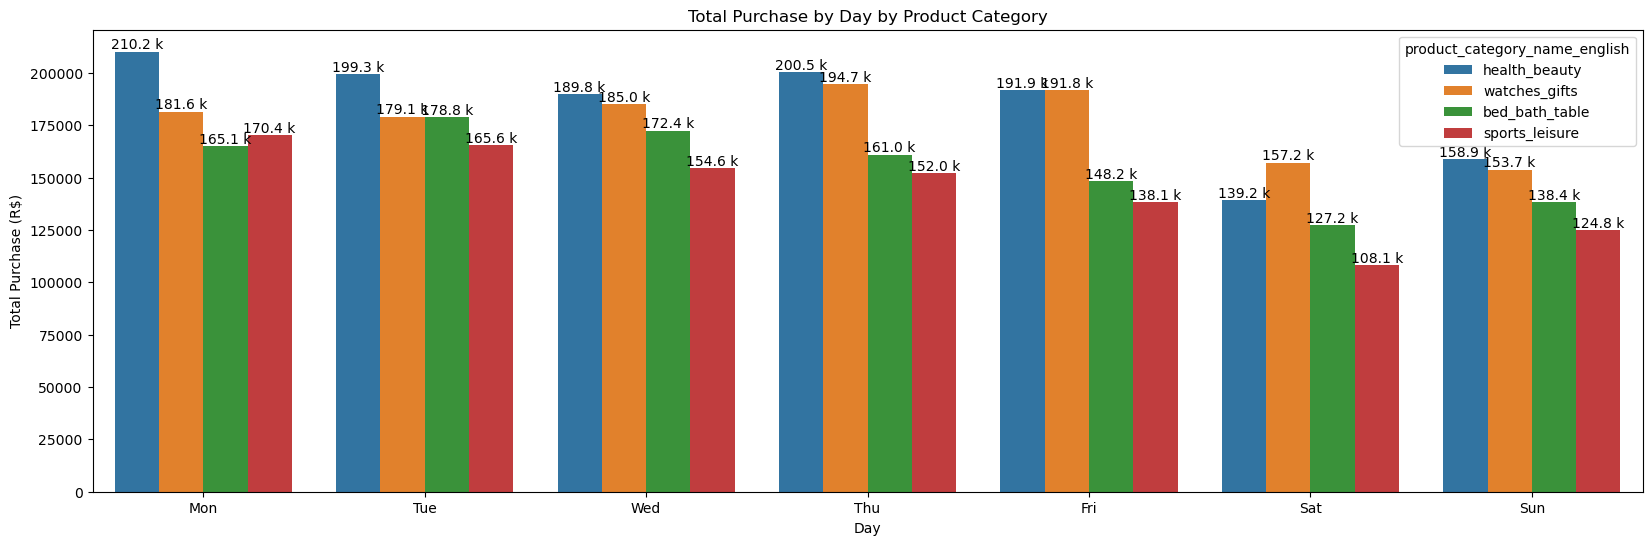

In [123]:
# Mempersiapkan data untuk membuat grafik
top_list = list(df_product_cat_top10['product_category_name_english'].head(4))

df_support = df_orders.copy()
df_support['weekday'] = df_support['date'].dt.weekday
df_support = df_support.groupby(by=['product_category_name_english','weekday']).sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)

df_support = df_support[df_support['product_category_name_english'].isin(top_list)]

# Membuat grafik total purchase berdasarkan hari pada setiap top product category
plt.figure(figsize = (20,6))
ax = sns.barplot(data=df_support,x='weekday',y='purchase',ci=True,hue='product_category_name_english')
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 1)} k'  for h in bar.datavalues])
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Day')
plt.title('Total Purchase by Day by Product Category')

plt.show()

#### **Rekomendasi 3** :
Terlihat memang ada beberapa kategori produk yang lebih laku daripada yang lain, untuk mendukung penjualan kategori produk tersebut kita bisa mencoba membuat campaign khusus berdasarkan hari seperti :

        •  Mon, Thu untuk beauty day
        •  Fri, Sat untuk watches day
        •  Tue, Wed untuk bed-bath day

Selain itu kita juga perlu memastikan ketersedian supply dari produk tersebut, jika ada pembelian tapi tiba-tiba tidak ada stok selain bisa mengcancel pesanan tersebut kita bisa mendapat ulasan jelek dari customer yang dikecewakan padahal itu bukan salah kita

        Cara paling mudah kita bisa memberi notifikasi kepada seller untuk memastikan ketersedian stok karena kategori produk tersebut banyak dibeli

---

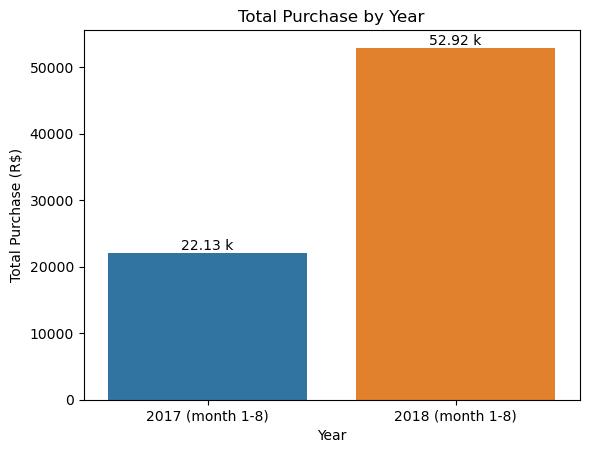

In [124]:
# Mempersiapkan data untuk membuat grafik
df_support = df_orders[['order_id','month']].drop_duplicates()
volume_2017 = df_support[(df_support['month']>='2017-01')&(df_support['month']<='2017-08')]
volume_2018 = df_support[(df_support['month']>='2018-01')&(df_support['month']<='2018-08')]

df_support = pd.DataFrame({
    'year': ['2017 (month 1-8)','2018 (month 1-8)'],
    'volume': [len(volume_2017),len(volume_2018)],
})

# Membuat garfik total pembelian berdasarkan tahun 2017 dan 2018
ax= sns.barplot(data=df_support,x='year',y='volume')
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 2)} k'  for h in bar.datavalues])
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Year')
plt.title('Total Purchase by Year')

plt.show()

#### **Rekomendasi 4** :
Terlihat peningkatan jumlah transaksi yang cukup signifikan antara tahun 2017 ke 2018, artinya semakin banyak pesanan terjadi di dalam platform. Disini kami merekomendasikan bagaimana jika di tahun 2019 nanti kita membuat app khusus seller untuk meningkatkan performa layanan pada orderan yang tiap tahun semakin bertambah.

Keuntungan untuk seller adalah :

     • Lebih fast respond membalas pertanyaan customer yang dapat memperbesar conversion rate
     • Analytical marketing untuk seller lebih mudah dan bisa menunjang marketing mereka

Keuntungan bagi kita adalah :

     • Lebih mudah berhubungan dengan seller seperti untuk notifikasi stok pada poin sebelumnya
     • Memperkecil layanan buruk dari seller yang berimbas pada reputasi kita, terutama dari new user

#### **FYI**

Hal ini benar-benar dilakukan olist di dunia nyata, pada Mei 2019 mereka merilis appseller mereka sendiri

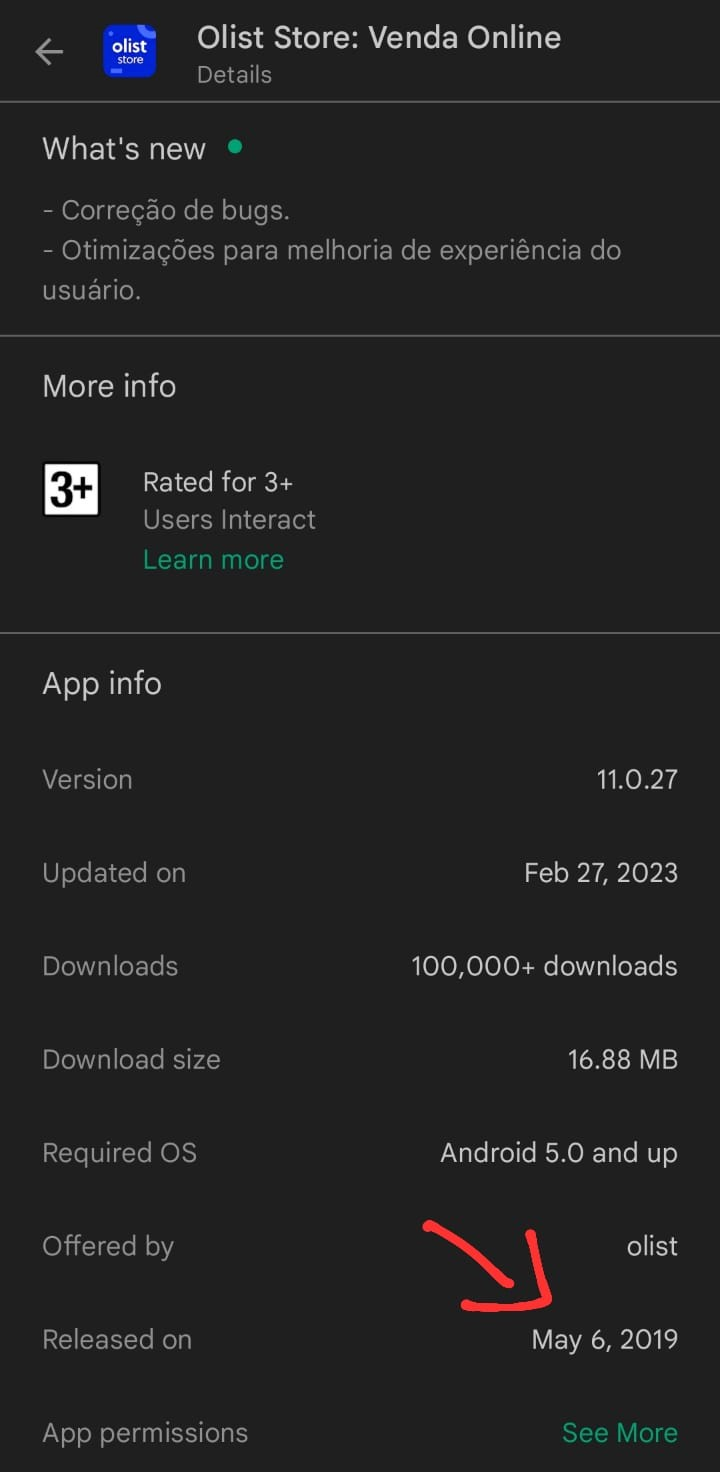

In [125]:
Image('olist appseller.jpg')

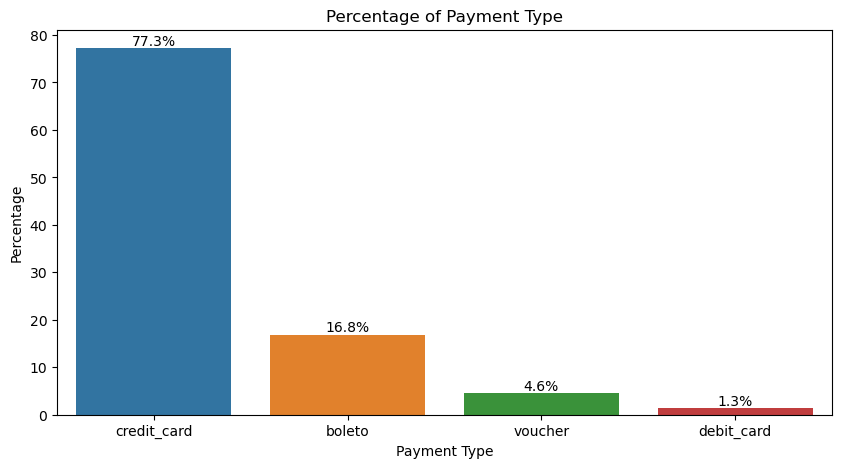

In [126]:
# Mempersiapkan data untuk membuat grafik
df_support = df_orders.groupby(by='payment_type').sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)
df_support['percentage'] = (df_support['purchase']/df_support['purchase'].sum())*100


# Membuat grafik persentase jenis transaksi yang dilakukan dalam melakukan pembelian
plt.figure(figsize = (10,5))
ax = sns.barplot(data=df_support,x='payment_type',y='percentage')

for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h, 1)}%' for h in bar.datavalues])

ax.set(xlabel='Payment Type', ylabel='Percentage',
       title='Percentage of Payment Type')

plt.show()

#### **Rekomendasi 5** :
77% Custommer mempunyai kebiasaan Buy Now Pay Later, kita bisa membuka layanan pay later sendiri dengan rate cicilan lebih rendah.

Kedepannya tidak menutup kemungkinan kita bisa mendiversifikasi produk kita menjadi layanan keuangan untuk transaksi diluar platform kita.

---

#### **Selesai**
**Sekian Terimakasih**